In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from scipy.signal import correlate
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.ndimage import uniform_filter1d
import h5py

In [2]:
# Plot style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=20)          # text size
plt.rc('axes', titlesize=24)     # axes title size
plt.rc('axes', labelsize=24)     # axes label size
plt.rc('xtick', labelsize=24)    # x-tick label size
plt.rc('ytick', labelsize=24)    # y-tick label size
plt.rc('legend', fontsize=24)    # legend font size
plt.rc('figure', titlesize=24)   # figure title size

In [3]:
def extract_data(folder):
    data_dict = {}

    for filename in os.listdir(folder):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder, filename)
            file_key = os.path.splitext(filename)[0]

            try:
                # Try loading with scipy.io (for most MATLAB files)
                mat_data = sio.loadmat(file_path)
                clean_data = {k: v for k, v in mat_data.items() if not k.startswith('__')}

            except NotImplementedError:
                # If it's a v7.3 (HDF5-based) file, use h5py
                with h5py.File(file_path, 'r') as f:
                    clean_data = {}
                    def recursively_load(name, obj):
                        if isinstance(obj, h5py.Dataset):
                            clean_data[name] = np.array(obj)
                    f.visititems(recursively_load)

            # Extract 'dataArray' key from file structure
            if 'dataArray' in clean_data:
                arr = clean_data['dataArray']
                if arr.ndim == 2 and arr.shape[1] >= 2:
                    HN_data = arr[:, 0]
                    WL_data = arr[:, 1]

                    data_dict[f'{file_key}_HN_data'] = HN_data
                    data_dict[f'{file_key}_WL_data'] = WL_data

            # Metadata stored here in case it is needed later
            meta = {}
            for key in ['runTime', 'xCenCorrection', 'xLinear', 'xLinearStage']:
                if key in clean_data:
                    meta[key] = clean_data[key]
            data_dict[f'{file_key}_meta'] = meta

    return data_dict

In [4]:
def nfft(a, axis=0):
    '''Numpy equivalent of MATLAB's ifftshift(fft(fftshift(a)))'''
    return np.fft.ifftshift(np.fft.fft(np.fft.fftshift(a, axes=axis), axis=axis), axes=axis)


def nifft(a, axis=0):
    '''Numpy equivalent of MATLAB's fftshift(ifft(ifftshift(a)))'''
    return np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(a, axes=axis), axis=axis), axes=axis)


def smooth(data, window_size):
    '''Simple moving average smoothing'''
    return uniform_filter1d(data, size=window_size, mode='nearest')

In [5]:
def calibrateDelayAxis(v, xL):
    '''
    Calibrate the delay axis using knowledge of the HeNe wavelength.
    Taken from dataProcessing code in MatLab (absolutely disgusting). 
    
    Params:
    -----------
    v: HeNe voltage/intensity signal
    xL: Linear x-grid (delay axis)
    
    Outputs:
    --------
    xNL: Nonlinear corrected x-grid
    '''
    # HeNe wavelength in mm
    lambdaHeNe = 0.6328/1000  # 632.8 nm converted to mm
    
    # Angular wave number
    k = 2*np.pi/lambdaHeNe
    
    # Step size
    dx_mm = np.mean(np.diff(xL))
    
    # Number of points in the grid
    N = len(xL)
    
    # Spatial frequency grid
    # Step size in frequency domain
    dfx = 1/(dx_mm*N)
    
    # Maximum extent
    fxMax = 1/dx_mm
    
    # Frequency grid
    fx = np.arange(-fxMax/2, fxMax/2, dfx)
    
    # Ensure fx and v have the same length
    if len(fx) > N:
        fx = fx[:N]
    elif len(fx) < N:
        fx = np.linspace(-fxMax/2, fxMax/2, N)
    
    # Take the Fourier transform of the voltage array
    V = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(v)))
    
    # The AC peak is located near
    p0 = 1/lambdaHeNe
    
    # Find the nearest pixel to this location
    idx = np.argmin(np.abs(p0 - fx))
    idx0 = np.argmin(np.abs(fx))
    
    # Construct a super-Gaussian filter
    # Super-Gaussian order
    n = 22
    
    # Half-width
    sigma = (idx - (N/2 + 1))*dfx*0.25
    
    # Filter
    G = np.exp(-((fx - fx[idx])**n)/(sigma**n))
    
    # Multiply by the filter and circshift to the center
    V = np.roll(G*V, -(idx - idx0))
    
    # Inverse Fourier transform
    v2 = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(V)))
    
    # Extract the phase and unwrap
    phi = np.unwrap(np.angle(v2))
    
    # Solve for the position dependent correction
    delta_x = phi/k
    
    # Add these deltas back to the original x-grid
    xNL = xL + delta_x
    
    return xNL

In [6]:
def removeLinearTerm(w, phase):
    '''Remove linear term from phase using polynomial fit'''
    idx = ~np.isnan(phase)
    if np.sum(idx) < 2:
        return phase
    
    nanPhase = phase[idx]
    nanW = w[idx]
    
    # Fit linear polynomial
    p = np.polyfit(nanW, nanPhase, 1)
    phase = phase - p[0]*w - p[1]
    
    return phase

def calculateZeroDelayCorrection(w, dw, xL, wl_data):
    '''Calculate zero delay correction from white light data'''
    wlSpec = nfft(wl_data - np.median(wl_data))
    wlSpec[w < 0] = 0
    
    # Calculate center of mass in frequency domain
    wCen = np.sum(w*np.abs(wlSpec)**2)/np.sum(np.abs(wlSpec)**2)
    wCenPx = int(np.round(wCen/dw))
    wlSpec = np.roll(wlSpec, -wCenPx)
    
    wlTemp = smooth(np.abs(nifft(smooth(wlSpec, 5)))**2, 5)
    
    xCen = np.sum(xL*wlTemp)/np.sum(wlTemp)
    
    return xCen, wlSpec

In [7]:
def WLI_processData(dataArray, xL, start_idx=None, end_idx=None):
    '''    
    Params:
    -----------
    dataArray: 2D array with columns [HeNe, WhiteLight]
    xL: Linear delay axis
    start_idx, end_idx: Optional indices to slice the data
    
    Outputs:
    --------
    xCen: Zero delay correction
    spectrum: Processed spectrum (HeNe and WL)
    wLPhase: Unwrapped white light phase
    lambda_vals: Wavelength array
    '''
    
    # Slice data if indices provided
    if start_idx is not None and end_idx is not None:
        dataArray = dataArray[start_idx:end_idx, :]
        xL = xL[start_idx:end_idx]
    
    N = len(dataArray)
    heneData = dataArray[:, 0]
    
    # Calibrate delay axis (simplified - keeping linear for now)
    xNL = calibrateDelayAxis(heneData, xL)
    
    # Interpolate data onto calibrated axis
    #f_hene = interp1d(xNL, heneData, kind='cubic', fill_value=0, bounds_error=False)
    #f_wl = interp1d(xNL, dataArray[:, 1], kind='cubic', fill_value=0, bounds_error=False)

    interp_hene = PchipInterpolator(xNL, heneData, extrapolate=False)
    interp_wl = PchipInterpolator(xNL, dataArray[:, 1], extrapolate=False)

    f_hene = np.nan_to_num(interp_hene(xL), nan=0.0)
    f_wl = np.nan_to_num(interp_wl(xL), nan=0.0)
    
    dataArray_interp = np.column_stack([f_hene, f_wl])
    
    # Calculate frequency axis
    c_mm_ps = 0.3  # Speed of light, mm/ps
    t = 2*xL/c_mm_ps

    #print(f'  DEBUG N: {N}')
    #print(f'  DEBUG xL range: {xL[0]:.6f} to {xL[-1]:.6f} mm')
    #print(f'  DEBUG t range: {t[0]:.6f} to {t[-1]:.6f} ps')
    #print(f'  DEBUG max(abs(t)): {np.max(np.abs(t)):.6} ps')
    
    dw = 2*np.pi/(np.max(np.abs(t)))# - np.min(np.abs(t)))
    wMax = dw*N

    #print(f'  DEBUG dw: {dw:.6f} rad/ps')
    #print(f'  DEBUG wMax: {wMax:.6f} rad/ps')
    
    w = np.arange(-wMax/2, wMax/2, dw)

    #print(f'  DEBUG len(w) before adjustment: {len(w)}')
    #print(f'  DEBUG w range: {w[0]:.6f} to {w[-1]:.6f} rad/ps')
    
    # Ensure w and data have same length
    if len(w) > N:
        w = w[:N]
    elif len(w) < N:
        # Pad or trim as needed
        w = np.linspace(-wMax/2, wMax/2, N)
    #print(f'  DEBUG len(w) after adjustment: {len(w)}')
    
    # Convert to wavelength (in microns)
    lambda_vals = (2*np.pi*c_mm_ps/w)*1000
    idx = (lambda_vals > 0.2) & (lambda_vals < 1.5)
    lambda_vals = lambda_vals[idx]
    w_selected = w[idx]
    
    # Calculate zero delay correction
    xCen = calculateZeroDelayCorrection(w, dw, xL, dataArray_interp[:, 1])[0]
    
    # Process field - subtract baseline
    # Use median subtraction like MATLAB: dataArray(256,:) for reference point
    ref_idx = N//4  # Integer division; 256 for N=1024
    field = dataArray_interp - dataArray_interp[ref_idx, :]
    field[field < -0.03] = 0
    field = nfft(field, axis=0)
    
    # Calculate spectrum
    spectrum = np.abs(field)**2
    hene_peak_idx = np.argmax(spectrum[:, 0])
    
    # Extract white light phase from selected frequency range
    wLPhase = np.unwrap(np.angle(field[idx, 1]))
    
    # Smooth and normalize spectrum in selected range
    spectrum = spectrum[idx, :]
    spectrum[:, 0] = smooth(spectrum[:, 0], 5)

    #print(f'  DEBUG HeNe peak at index: {hene_peak_idx}')
    #print(f'  DEBUG HeNe peak wavelength: {lambda_vals[hene_peak_idx]:.3f} um')
    
    # Normalize each column independently
    for col in range(spectrum.shape[1]):
        spec_min = np.min(spectrum[:, col])
        spec_max = np.max(spectrum[:, col])
        if spec_max > spec_min:
            spectrum[:, col] = (spectrum[:, col] - spec_min)/(spec_max - spec_min)
    
    # Mask low-intensity regions in phase (blank where WL spectrum is weak)
    phaseBlank = spectrum[:, 1] < 0.1
    wLPhase[phaseBlank] = np.nan
    
    # Remove linear term from phase using frequency axis
    wLPhase = removeLinearTerm(w_selected, wLPhase)
    
    # Smooth phase (only non-NaN values)
    valid_idx = ~np.isnan(wLPhase)
    if np.sum(valid_idx) > 5:
        wLPhase_smooth = wLPhase.copy()
        wLPhase_smooth[valid_idx] = smooth(wLPhase[valid_idx], 5)
        wLPhase = wLPhase_smooth
    
    return xCen, spectrum, wLPhase, lambda_vals, w_selected

In [8]:
def fit_phase_polynomial(lambda_vals, phase, spectrum, degree=2):
    '''
    Params:
    -----------
    lambda_vals: Wavelength array
    phase: Phase array (may contain NaNs)
    spectrum: Spectrum array (2 cols: HeNe, WL)
    degree: Polynomial degree (default=2 for quadratic)
    
    Outputs:
    --------
    coeffs: Polynomial coefficients
    phase_fit: Fitted phase values
    lambda_cont: Wavelength values only in continuous region
    phase_cont: phase values only in continuous region
    spectrum_cont: spectrum values only in continuous region
    r_squared: R^2 goodness of fit 
    '''
    # Removes NaN values
    valid_idx = ~np.isnan(phase)
    
    if np.sum(valid_idx) < degree + 1:
        return None, None
        
    # Find continuous valid region   
    valid_positions = np.where(valid_idx)[0]
    start_idx = valid_positions[0]
    end_idx = valid_positions[-1]+1

    # Extract continuous region
    lambda_cont = lambda_vals[start_idx:end_idx]
    phase_cont = phase[start_idx:end_idx]
    spectrum_cont = spectrum[start_idx:end_idx, :]

    # Sort by wavelength in ascending order
    #sort_idx = np.argsort(lambda_cont)
    #lambda_cont = lambda_cont[sort_idx]

    # Only fit not NaN points in region
    valid_in = ~np.isnan(phase_cont)

    if np.sum(valid_in)<degree+1:
        return None, None, None, None, None
    
    # Polynomial fit for phase
    coeffs = np.polyfit(lambda_cont[valid_in], phase_cont[valid_in], degree)
    
    # Evaluate polynomial
    phase_fit = np.polyval(coeffs, lambda_cont)

    # Calculate R^2 using only valid (non-NaN) points
    phase_valid = phase_cont[valid_in]
    phase_fit_valid = phase_fit[valid_in]

    # R^2 = 1 - (SS_res / SS_tot)
    ss_res = np.sum((phase_valid - phase_fit_valid)**2)  # Residual sum of squares
    ss_tot = np.sum((phase_valid - np.mean(phase_valid))**2)  # Total sum of squares
    
    r_squared = 1 - (ss_res/ss_tot)
    
    return coeffs, phase_fit, lambda_cont, phase_cont, spectrum_cont, r_squared

In [9]:
def shift_data(data, shift_indices):
    """
    Shift data by a given number of indices using circular shift (roll).
    
    Params:
    -----------
    data: Array to shift
    shift_indices: Number of indices to shift (positive = right, negative = left)
    
    Returns:
    --------
    shifted_data: Shifted array
    """
    return np.roll(data, shift_indices)

In [20]:
def plot_spectrum_and_phase(lambda_vals, spectrum, phase, phase_fit=None, lambda_trim=None, 
                            phase_trim=None, r_squared=None, title='WLI Data', save_fig=False, 
                            output_dir=None, filename=None, x_shift=0):
    '''    
    Params:
    -----------
    lambda_vals: Wavelength array in microns
    spectrum: Spectrum array (2 columns: HeNe, WL)
    phase: Phase array
    phase_fit: Fitted phase
    lambda_trim: Wavelength array for fit
    phase_trim: Phase data in continuous region
    r_squared: R^2 good of fit measurement
    title: Plot title
    x_shift: Number of indices to shift data horizontally (positive = right, negative = left)
    '''
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Shift the data if x_shift is specified
    if x_shift != 0:
        spectrum_shifted = np.zeros_like(spectrum)
        spectrum_shifted[:, 0] = shift_data(spectrum[:, 0], x_shift)  # Shift HeNe
        spectrum_shifted[:, 1] = shift_data(spectrum[:, 1], x_shift)  # Shift WL
        phase_shifted = shift_data(phase, x_shift)
        
        # Also shift the trimmed/fitted data if they exist
        if phase_trim is not None:
            # Find the indices of lambda_trim in lambda_vals
            trim_start_idx = np.where(np.isclose(lambda_vals, lambda_trim[0], atol=1e-6))[0]
            trim_end_idx = np.where(np.isclose(lambda_vals, lambda_trim[-1], atol=1e-6))[0]
            
            if len(trim_start_idx) > 0 and len(trim_end_idx) > 0:
                # Shift the trim indices
                new_start = (trim_start_idx[0] + x_shift) % len(lambda_vals)
                new_end = (trim_end_idx[0] + x_shift) % len(lambda_vals)
                
                # Handle wraparound cases
                if new_start <= new_end:
                    lambda_trim_plot = lambda_vals[new_start:new_end+1]
                    phase_trim_plot = phase_shifted[new_start:new_end+1]
                    if phase_fit is not None:
                        phase_fit_plot = shift_data(phase_fit, 0)  # Keep fit aligned with trimmed data
                else:
                    # Handle wrap-around case
                    lambda_trim_plot = lambda_trim
                    phase_trim_plot = phase_trim
                    phase_fit_plot = phase_fit
            else:
                lambda_trim_plot = lambda_trim
                phase_trim_plot = phase_trim
                phase_fit_plot = phase_fit
        else:
            lambda_trim_plot = lambda_trim
            phase_trim_plot = None
            phase_fit_plot = None
    else:
        spectrum_shifted = spectrum
        phase_shifted = phase
        lambda_trim_plot = lambda_trim
        phase_trim_plot = phase_trim
        phase_fit_plot = phase_fit
    
    # Plot Spectrum, left axis
    ax1.set_xlabel(r'$\lambda [\mu m]$', fontweight='bold')
    ax1.set_ylabel('Spectrum [a.u.]', fontweight='bold')
    ax1.plot(lambda_vals, spectrum_shifted[:, 0], label='HeNe', color='red', alpha=0.8)
    ax1.plot(lambda_vals, spectrum_shifted[:, 1], label='WL', color='black', alpha=0.8)
    ax1.tick_params(axis='y')
    ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax1.grid(True, alpha=0.4)
    
    # Plot phase on right axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Phase [rad]', fontweight='bold')

    # Will plot trimmed phase if there is one, otherwise full phase
    if phase_trim_plot is not None and lambda_trim_plot is not None:
        ax2.plot(lambda_trim_plot, phase_trim_plot, 'o-', label='Phase', color='darkorange', markersize=5, alpha=0.8)
    else:
        ax2.plot(lambda_vals, phase_shifted, 'o-', label='Phase', color='darkorange', markersize=5, alpha=0.8)

    if phase_fit_plot is not None and lambda_trim_plot is not None:
        if r_squared is not None:
            fit_label = f'Phase Fit \n (R^2 = {r_squared:.4f})'
        else:
            fit_label = f'Phase Fit'
        ax2.plot(lambda_trim_plot, phase_fit_plot, '--', label=fit_label, color='green', linewidth=2)
    
    ax2.tick_params(axis='y')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1+lines2, labels1+labels2, loc='upper right')
    # Add shift info to legend if shifted
    #if x_shift != 0:
    #    shift_label = f'Data shifted by {x_shift} indices'
    #    ax1.legend(lines1 + lines2 + [plt.Line2D([0], [0], color='none', label=shift_label)], 
    #              labels1 + labels2 + [shift_label], loc='lower left')
    #else:
    #    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')
    
    plt.title(title, fontweight='bold')
    plt.tight_layout()

    if save_fig and output_dir and filename:
        filepath = os.path.join(output_dir, f'{filename}.pdf')
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f'  Saved: {filename}.pdf')
        
    
    return fig, (ax1, ax2)

In [21]:
def plot_diagnostic(dataArray, xL, title='Interferogram', save_fig=False, output_dir=None, filename=None):
    '''
    Repurposed diagnostic plots function fro raw interferogram.
    
    Params:
    -----------
    dataArray: Original data array
    xL: Position axis
    title: Plot title
    '''
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(xL, dataArray[:,0], label='HeNe', color='red', alpha=0.7)
    plt.plot(xL, dataArray[:,1], label='WL', color='black', alpha=0.7)
    plt.xlabel('Position [mm]', fontweight='bold')
    plt.ylabel('Intensity', fontweight='bold')
    plt.title(f'{title}', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_fig and output_dir and filename:
        filepath = os.path.join(output_dir, f'{filename}.pdf')
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f'  Saved: {filename}.pdf')
    
    return fig

In [22]:
def calculate_GDD(coeffs, lambda_trim, spectrum_trim):
    """
    Calculate GDD from a phase-vs-wavelength polynomial fit.

    Parameters
    ----------
    coeffs : array-like
        Polynomial coefficients [a, b, c] for f(lambda) = a*lambda^2 + b*lambda + c
    lambda_trim : array-like
        Wavelength array in the continuous region (microns)
    spectrum_trim : array-like
        Full spectrum array (N x 2, with WL in second column)

    Returns
    -------
    GDD_fs2 : float
        Group delay dispersion in fs^2
    lambda_center : float
        Weighted center wavelength in microns
    """
    a, b, _ = coeffs

    # Extract WL spectrum if 2D array
    if spectrum_trim.ndim == 2:
        weights=spectrum_trim[:,1]
    else:
        weights = spectrum_trim
        
    valid = ~np.isnan(weights)&(weights>0)
    
    if np.sum(valid)==0:
        lambda_center=np.mean(lambda_trim)
    else:
        lambda_center = np.sum(lambda_trim[valid]*weights[valid])/np.sum(weights[valid])

    # Speed of light in um/fs
    c = 0.3

    # Full GDD expression
    #GDD = ((a)*lambda_center**4 + 2*(b)*lambda_center**3)/((2*np.pi*c)**2)
    # Remove linear term from defintion because should only have very small contribution. 
    GDD = 2*((a)*lambda_center**4)/((2*np.pi*c)**2)

    GDD_fs2 = GDD

    return GDD_fs2, lambda_center

Processing data from index 700 to 1900
Found 25 datasets
X-axis shift amount: 50 indices

Processing: raw_data_001_20251015
  Saved: raw_data_001_20251015_Interferogram.pdf


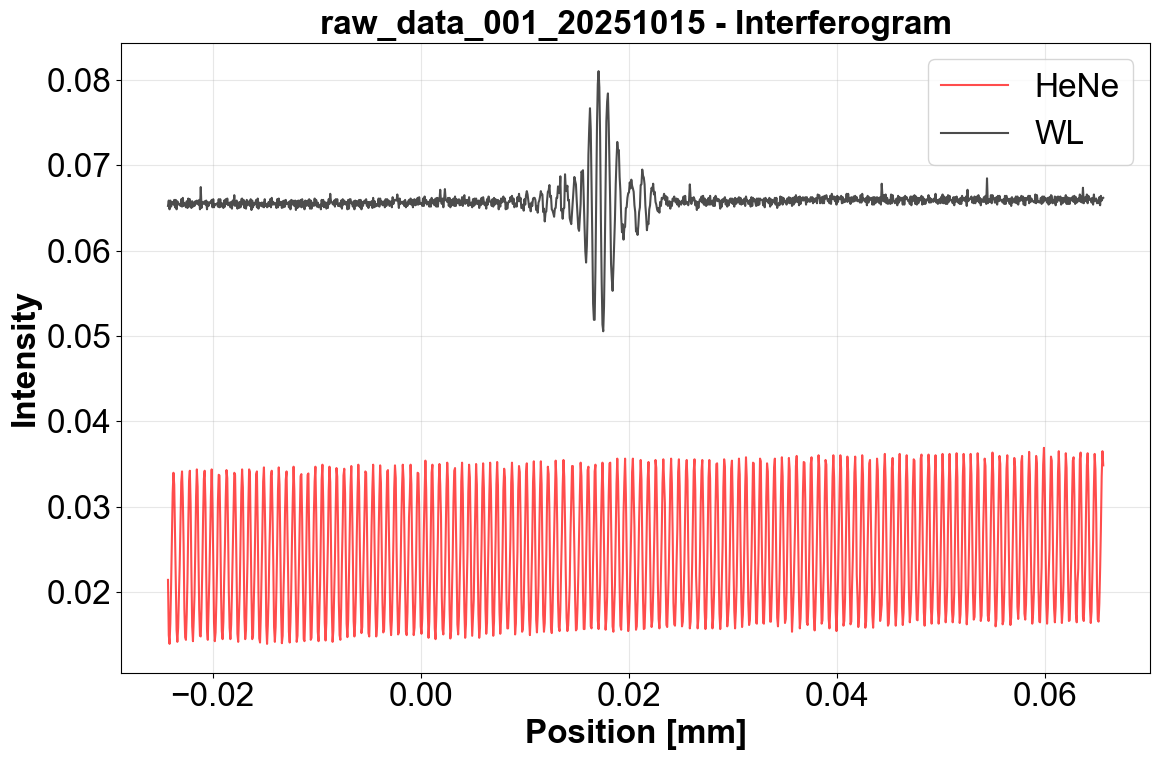

Zero delay correction: 0.026600
Polynomial coefficients: [ 13.85308456 -32.49883255  18.66401468]
Fit domain $\lambda$ = 1.491 to 0.905 $\mu m$
R^2 = 0.7782
GDD at $\lambda$ = 1.170 $\mu m$ (weighted): 14.62 fs^2
  Saved: raw_data_001_20251015_Spectrum_and_Phase.pdf


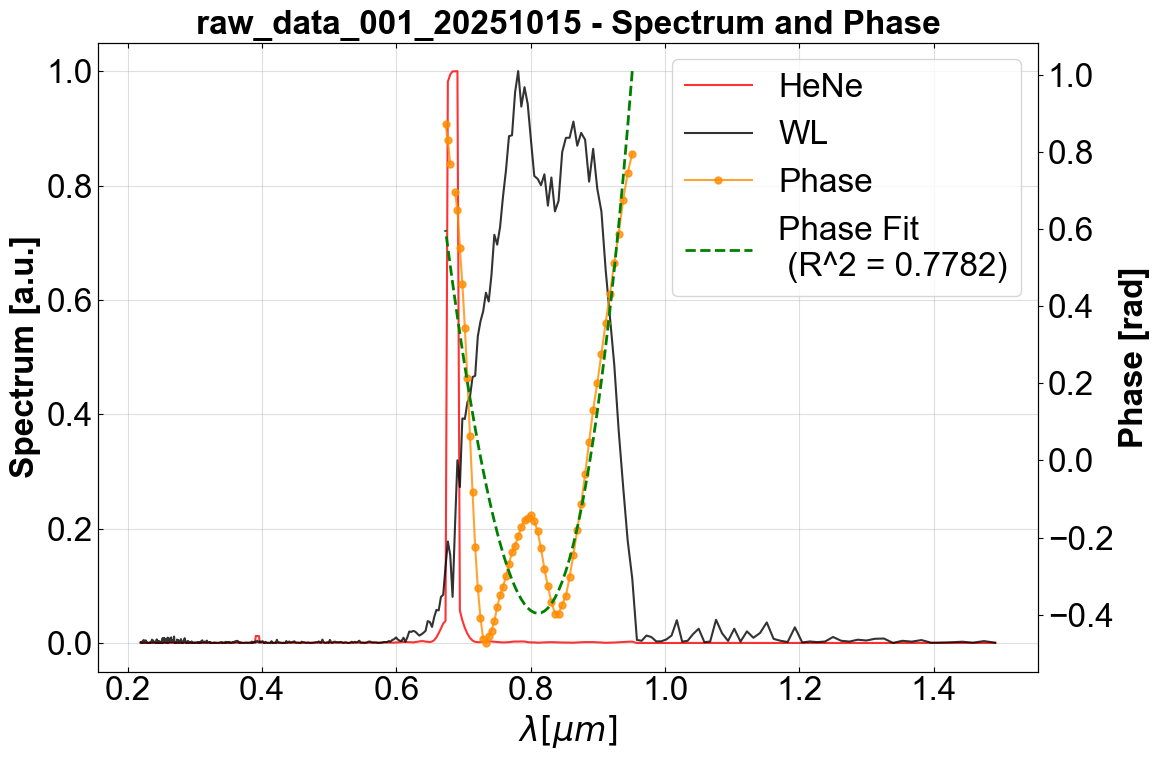


Processing: raw_data_002_20251015
  Saved: raw_data_002_20251015_Interferogram.pdf


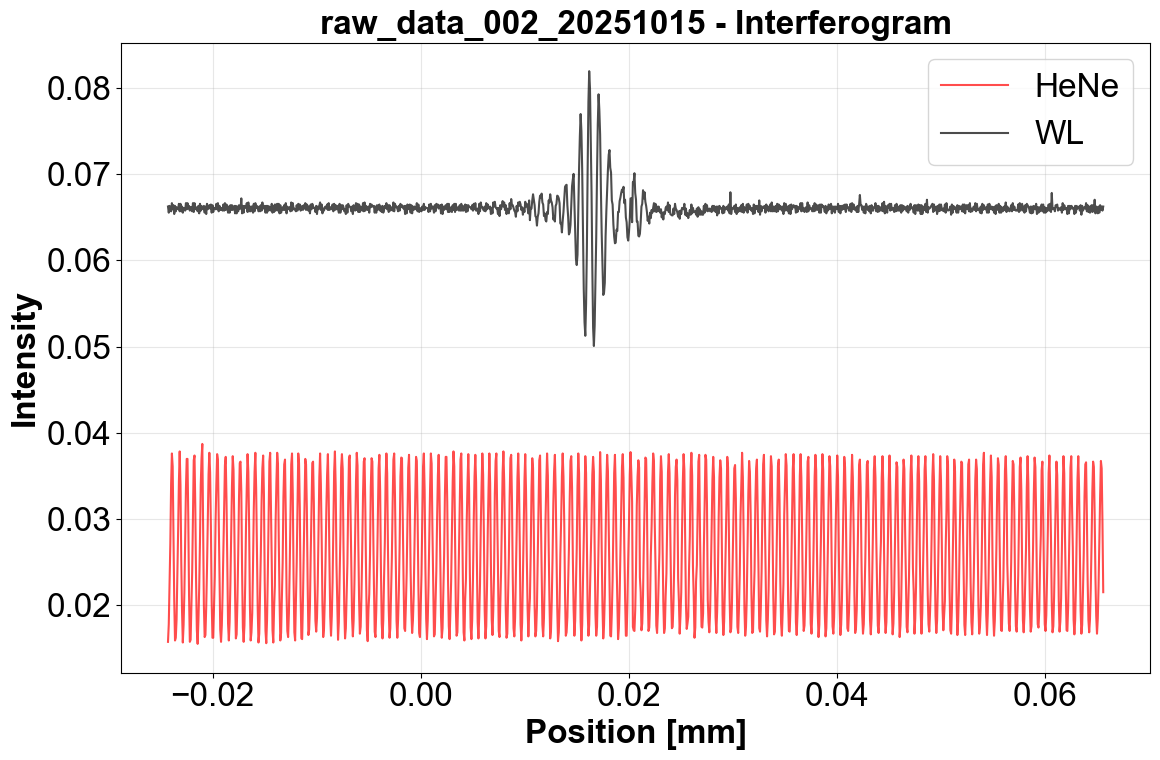

Zero delay correction: 0.026043
Polynomial coefficients: [ 13.09059575 -30.81724602  17.77025935]
Fit domain $\lambda$ = 1.491 to 0.911 $\mu m$
R^2 = 0.8202
GDD at $\lambda$ = 1.192 $\mu m$ (weighted): 14.90 fs^2
  Saved: raw_data_002_20251015_Spectrum_and_Phase.pdf


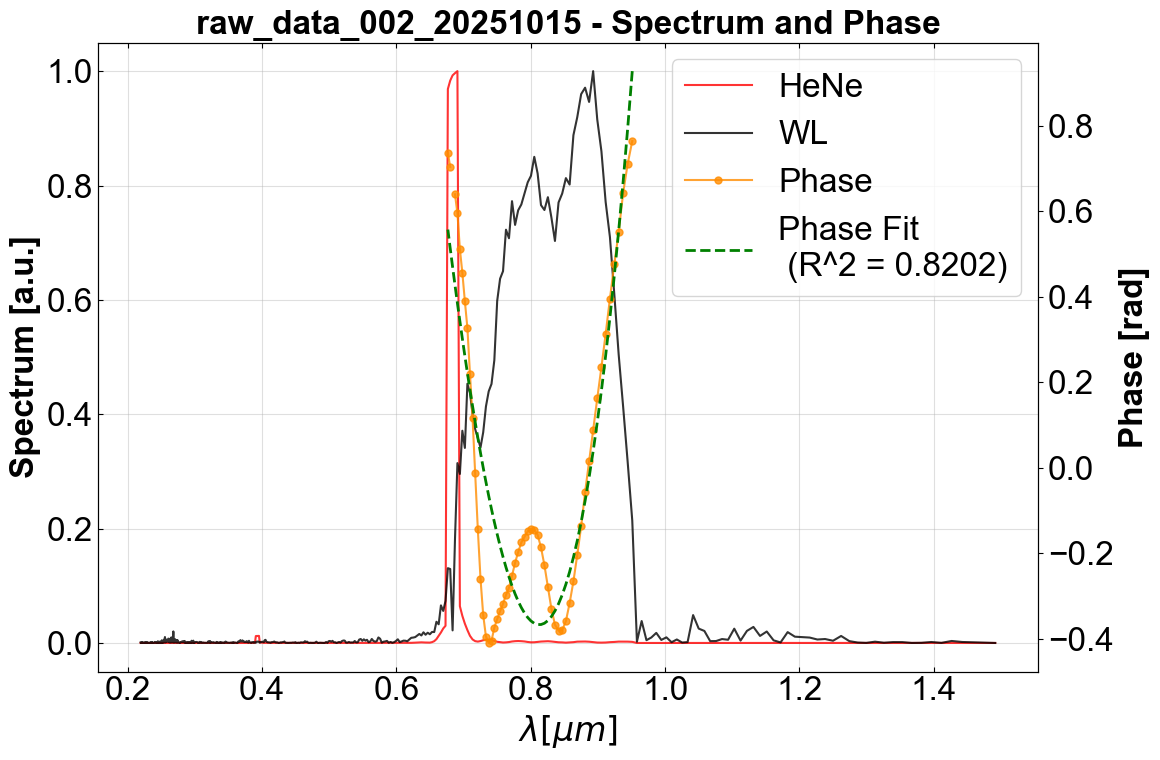


Processing: raw_data_003_20251015
  Saved: raw_data_003_20251015_Interferogram.pdf


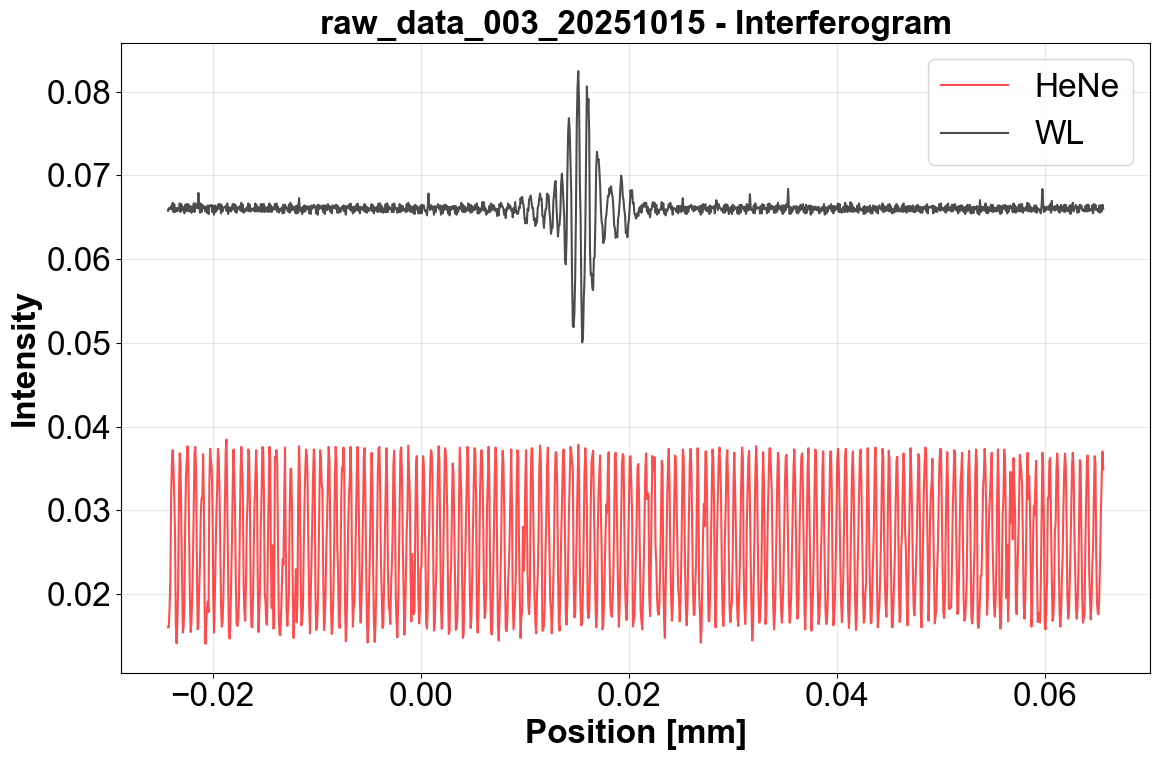

Zero delay correction: 0.026688
Polynomial coefficients: [ 12.32361393 -29.04393532  16.76846425]
Fit domain $\lambda$ = 1.491 to 0.918 $\mu m$
R^2 = 0.7574
GDD at $\lambda$ = 1.222 $\mu m$ (weighted): 15.48 fs^2
  Saved: raw_data_003_20251015_Spectrum_and_Phase.pdf


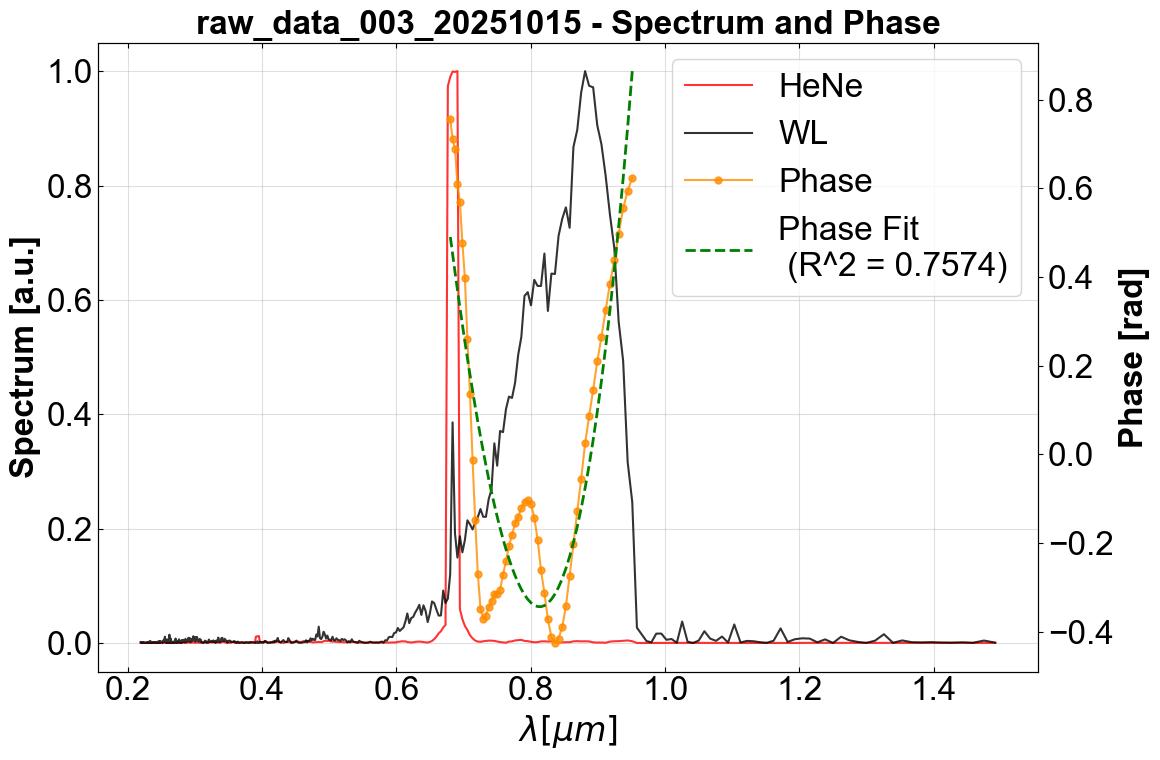


Processing: raw_data_004_20251015
  Saved: raw_data_004_20251015_Interferogram.pdf


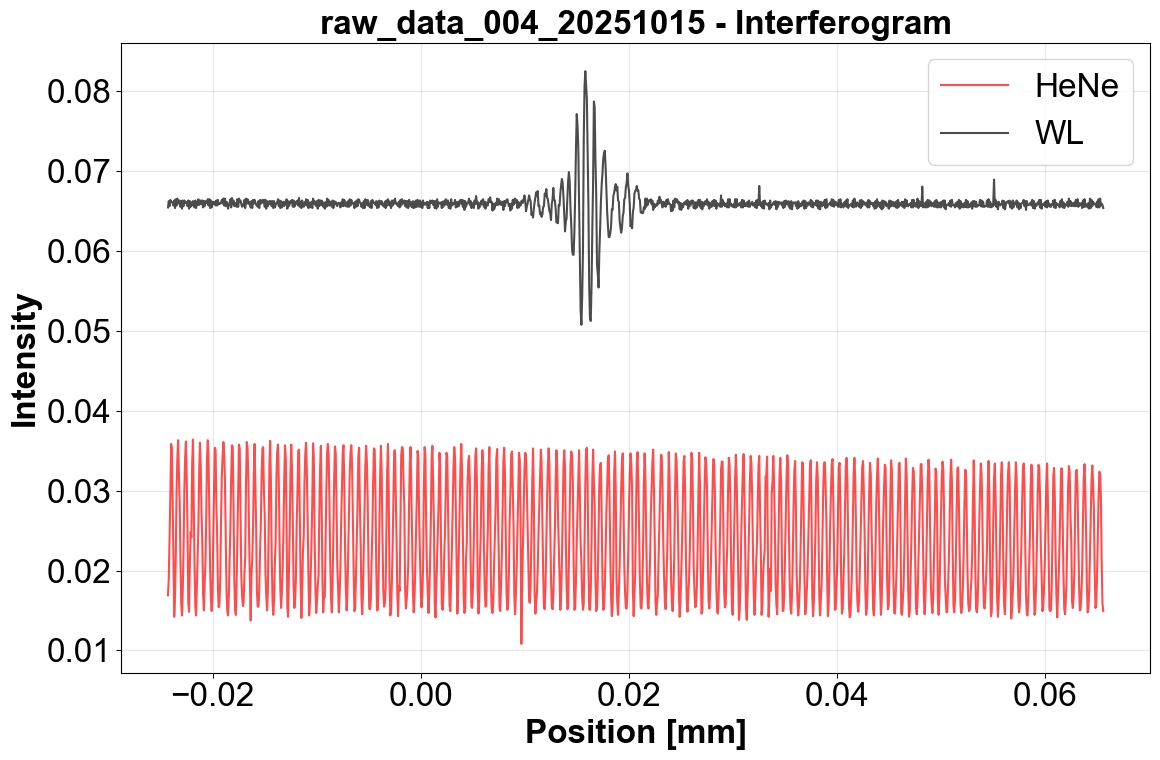

Zero delay correction: 0.030043
Polynomial coefficients: [ 14.77616659 -34.50913892  19.78746445]
Fit domain $\lambda$ = 1.458 to 0.924 $\mu m$
R^2 = 0.8637
GDD at $\lambda$ = 1.151 $\mu m$ (weighted): 14.62 fs^2
  Saved: raw_data_004_20251015_Spectrum_and_Phase.pdf


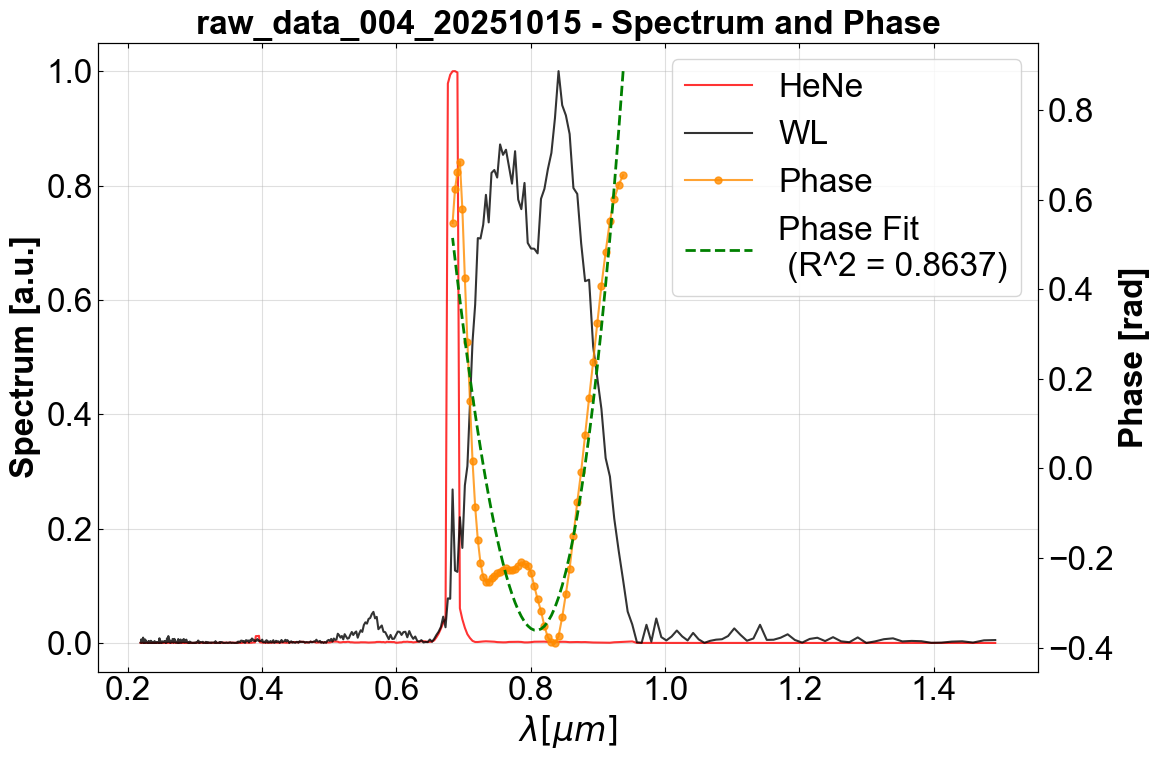


Processing: raw_data_005_20251015
  Saved: raw_data_005_20251015_Interferogram.pdf


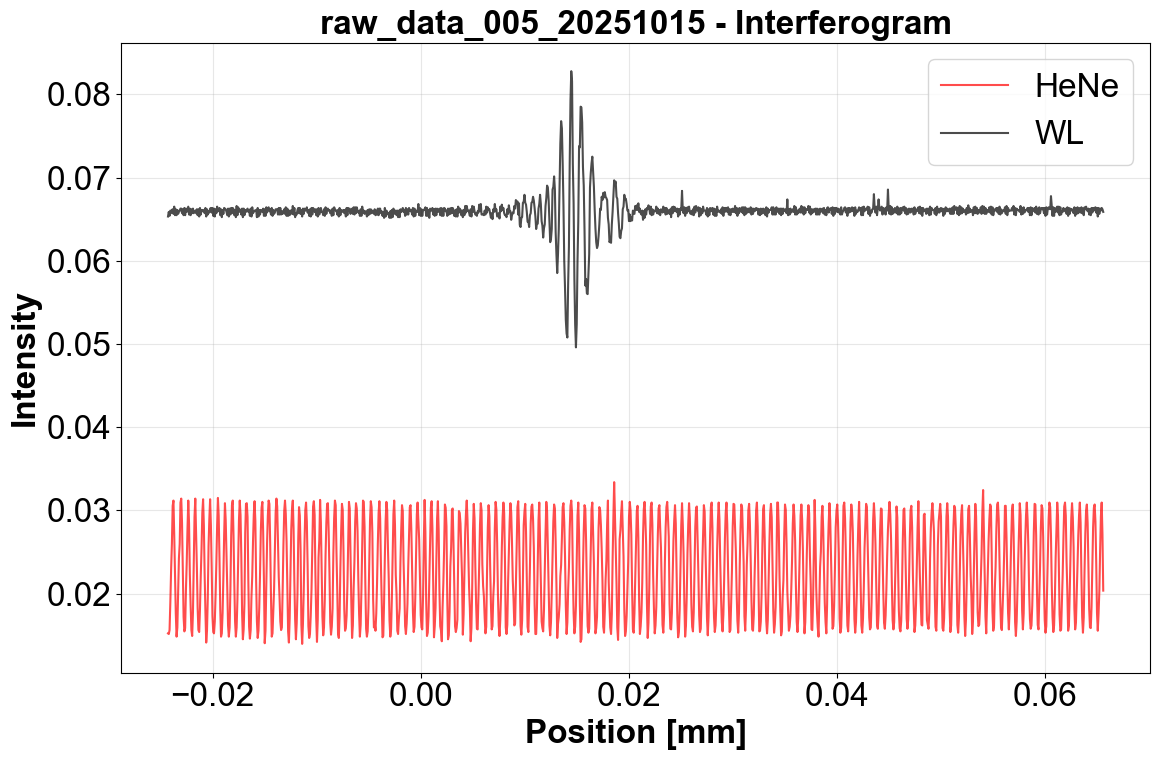

Zero delay correction: 0.026844
Polynomial coefficients: [ 11.75468275 -27.38711603  15.59508229]
Fit domain $\lambda$ = 1.491 to 0.899 $\mu m$
R^2 = 0.9500
GDD at $\lambda$ = 1.238 $\mu m$ (weighted): 15.56 fs^2
  Saved: raw_data_005_20251015_Spectrum_and_Phase.pdf


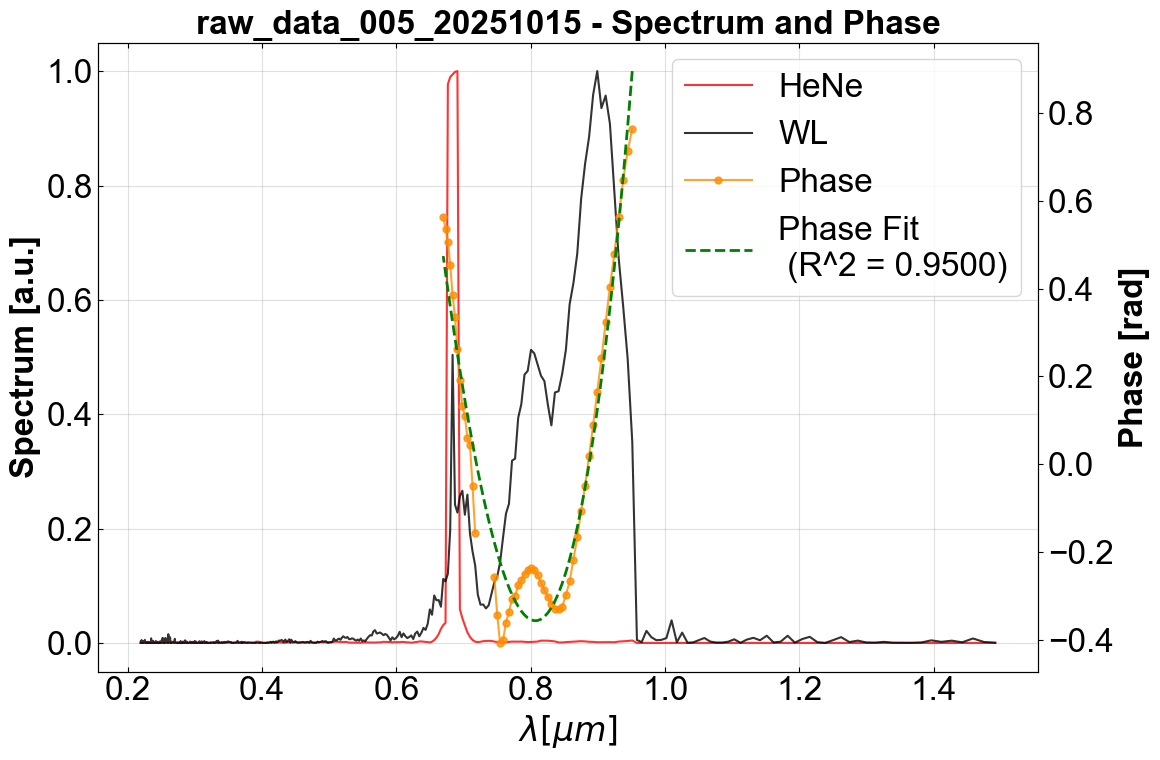


Processing: raw_data_006_20251015
  Saved: raw_data_006_20251015_Interferogram.pdf


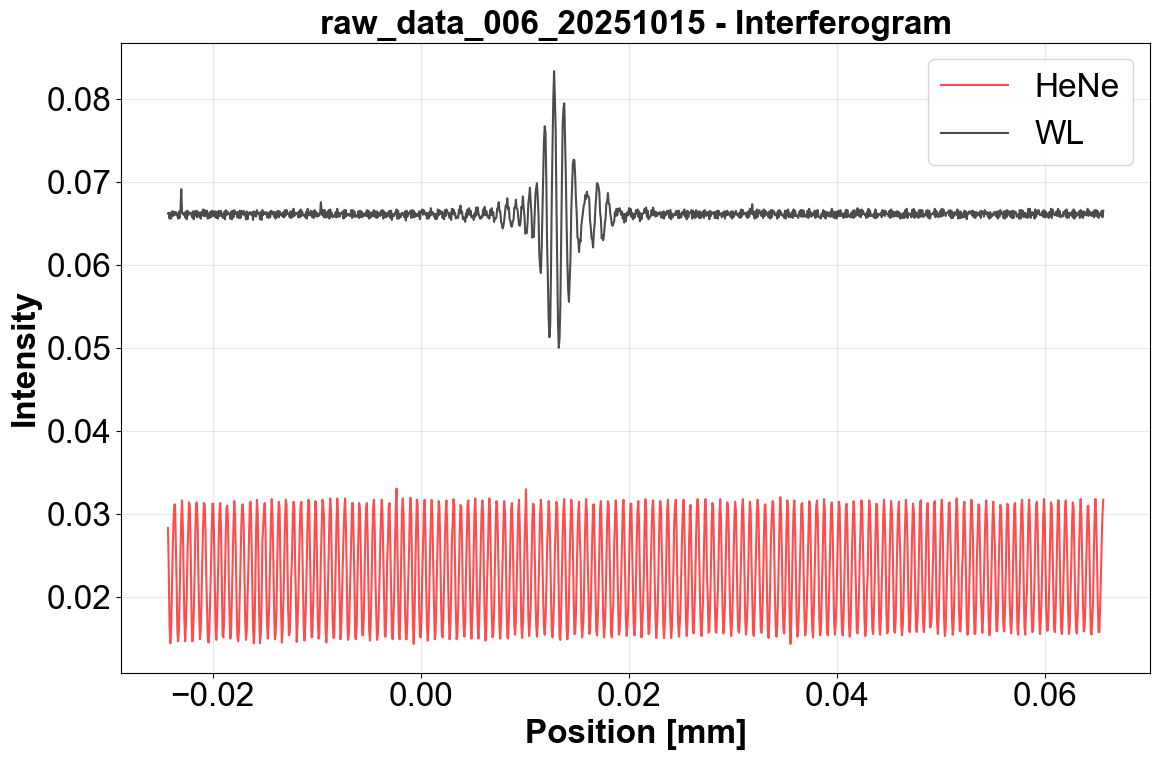

Zero delay correction: 0.028171
Polynomial coefficients: [ 13.14484205 -31.17329569  18.13045083]
Fit domain $\lambda$ = 1.491 to 0.931 $\mu m$
R^2 = 0.7228
GDD at $\lambda$ = 1.192 $\mu m$ (weighted): 14.93 fs^2
  Saved: raw_data_006_20251015_Spectrum_and_Phase.pdf


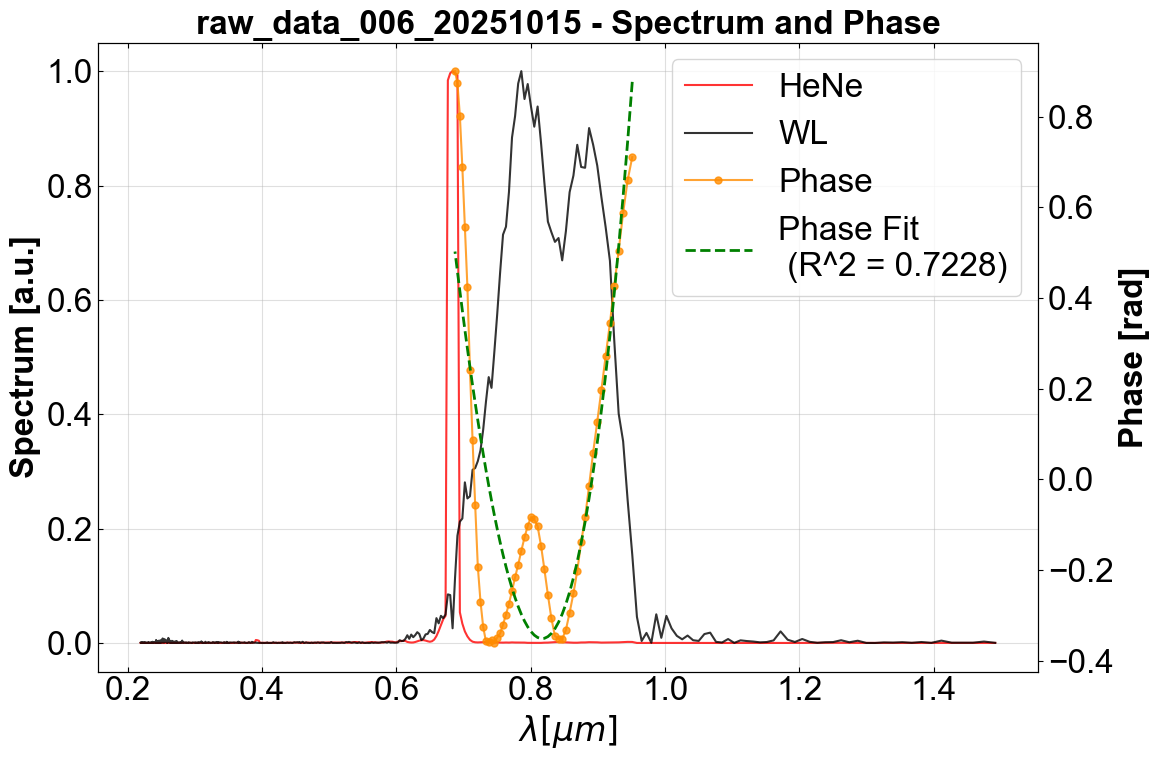


Processing: raw_data_007_20251015
  Saved: raw_data_007_20251015_Interferogram.pdf


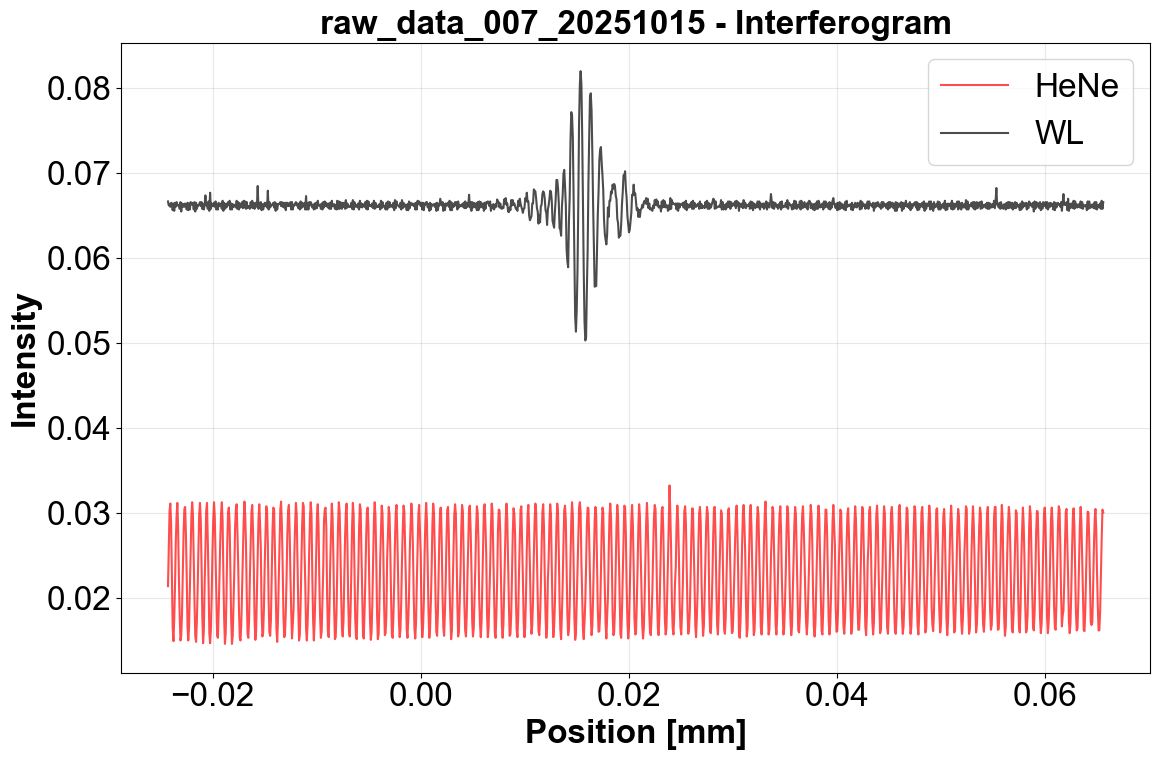

Zero delay correction: 0.030530
Polynomial coefficients: [ 13.97420907 -32.70350286  18.72733461]
Fit domain $\lambda$ = 1.491 to 0.905 $\mu m$
R^2 = 0.7780
GDD at $\lambda$ = 1.165 $\mu m$ (weighted): 14.50 fs^2
  Saved: raw_data_007_20251015_Spectrum_and_Phase.pdf


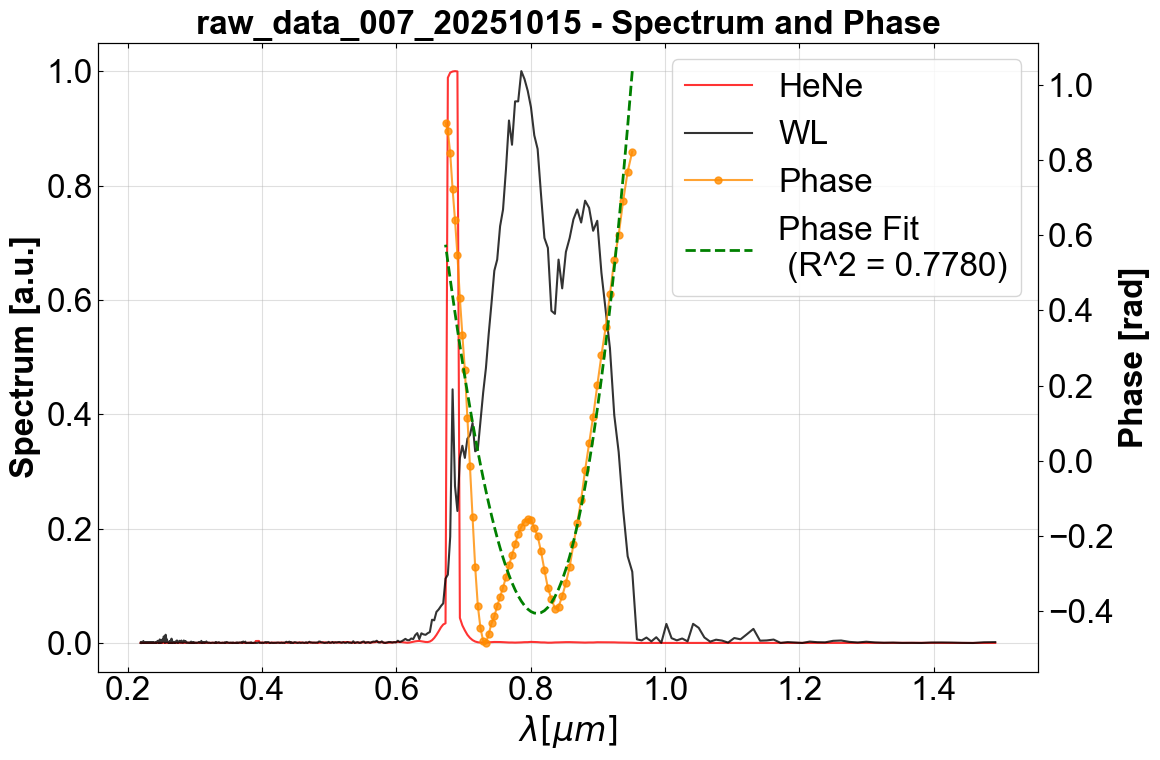


Processing: raw_data_008_20251015
  Saved: raw_data_008_20251015_Interferogram.pdf


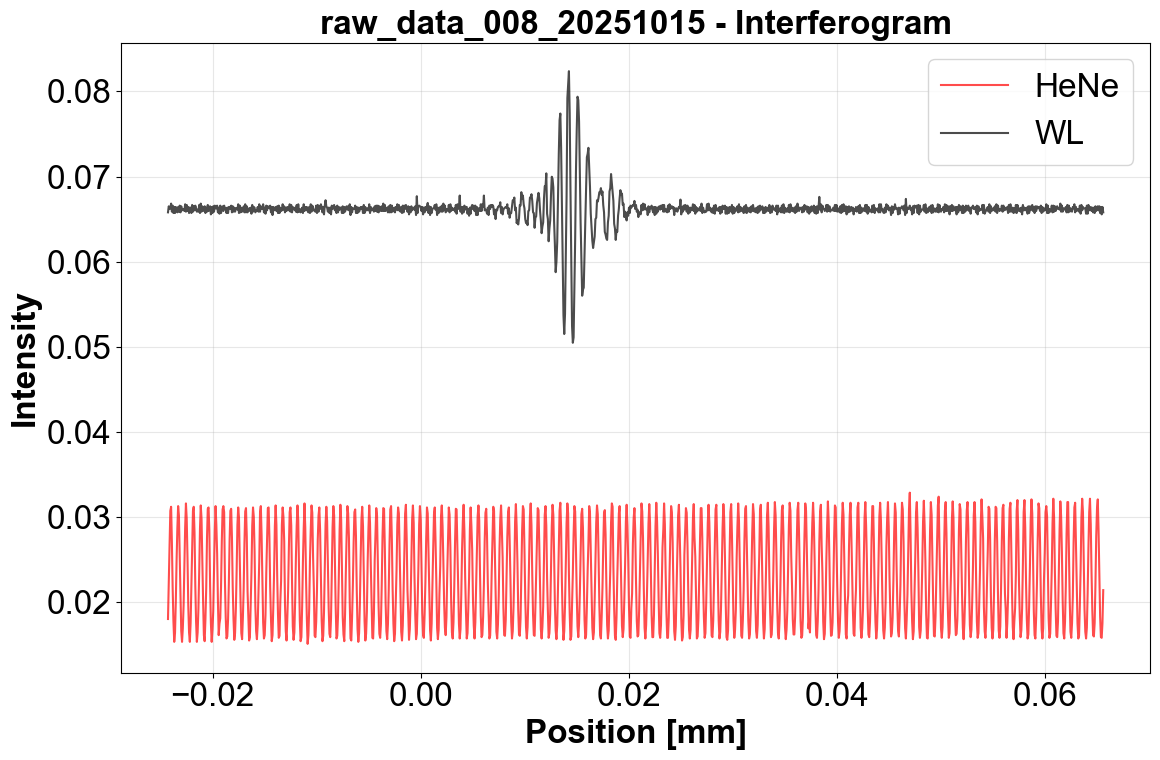

Zero delay correction: 0.030612
Polynomial coefficients: [ 15.64573045 -36.50917912  20.87581332]
Fit domain $\lambda$ = 1.475 to 0.905 $\mu m$
R^2 = 0.7714
GDD at $\lambda$ = 1.176 $\mu m$ (weighted): 16.85 fs^2
  Saved: raw_data_008_20251015_Spectrum_and_Phase.pdf


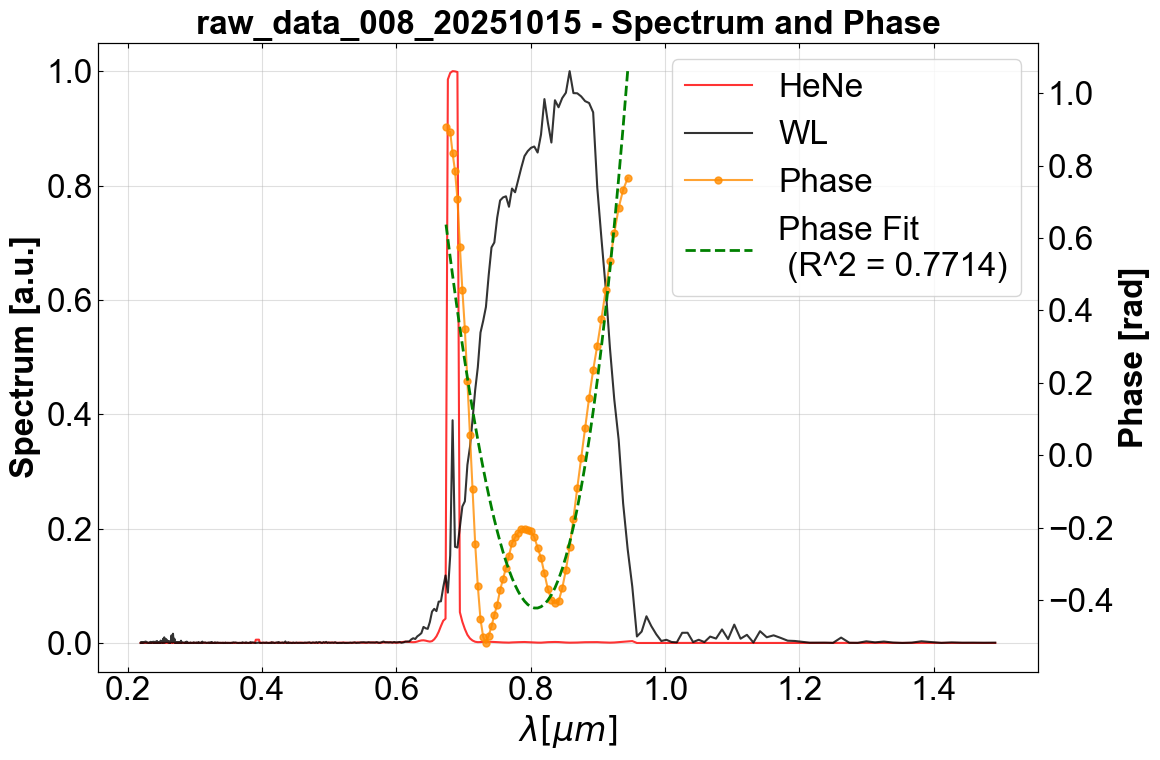


Processing: raw_data_009_20251015
  Saved: raw_data_009_20251015_Interferogram.pdf


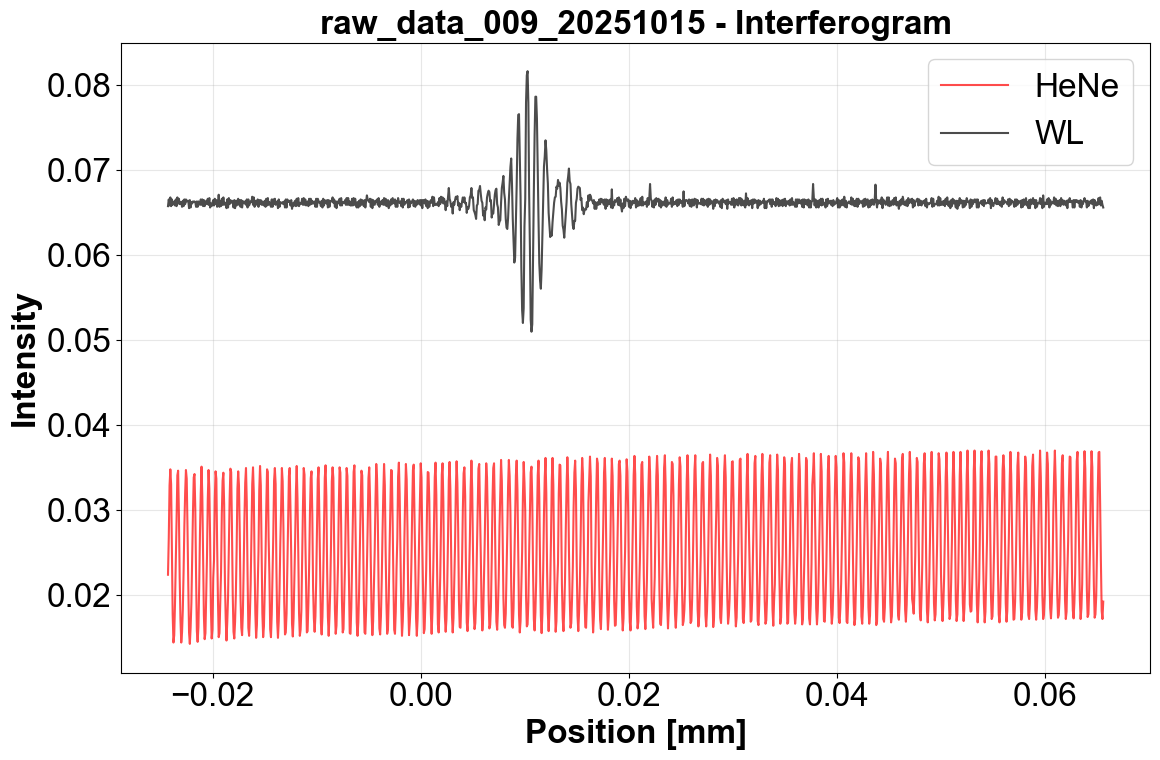

Zero delay correction: 0.031467
Polynomial coefficients: [ 15.72518421 -36.54052658  20.79156674]
Fit domain $\lambda$ = 1.475 to 0.899 $\mu m$
R^2 = 0.8559
GDD at $\lambda$ = 1.150 $\mu m$ (weighted): 15.49 fs^2
  Saved: raw_data_009_20251015_Spectrum_and_Phase.pdf


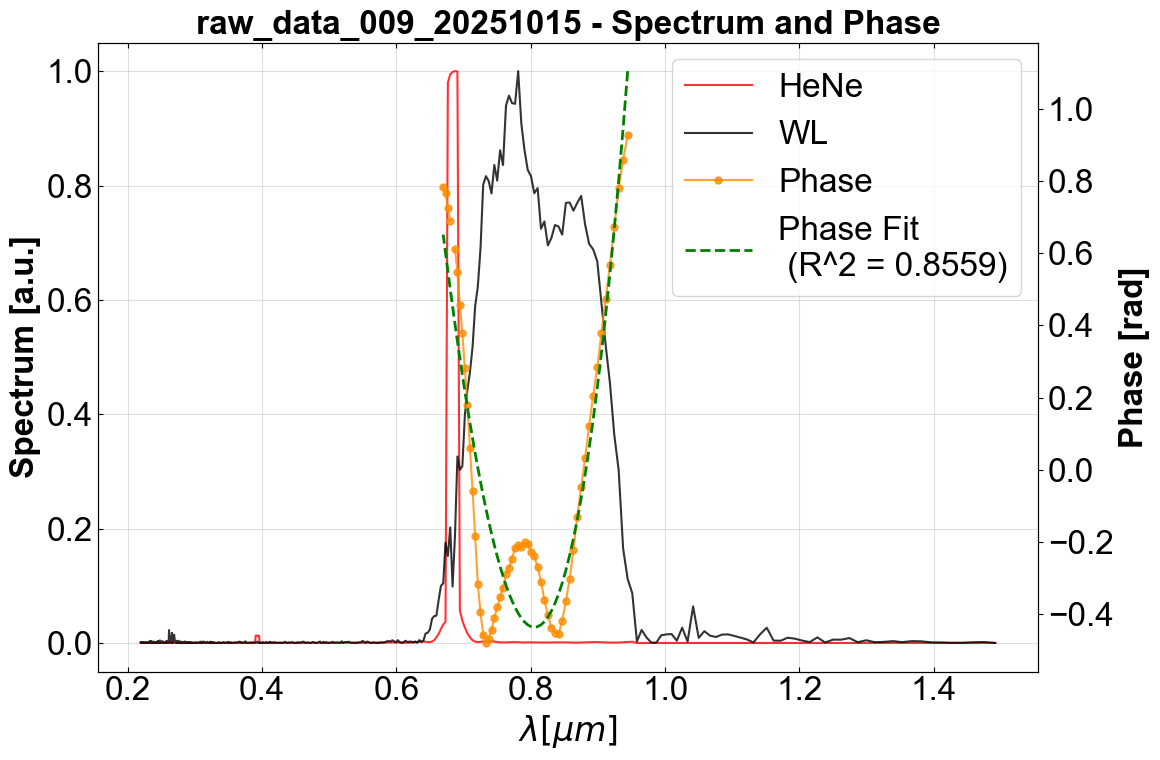


Processing: raw_data_010_20251015
  Saved: raw_data_010_20251015_Interferogram.pdf


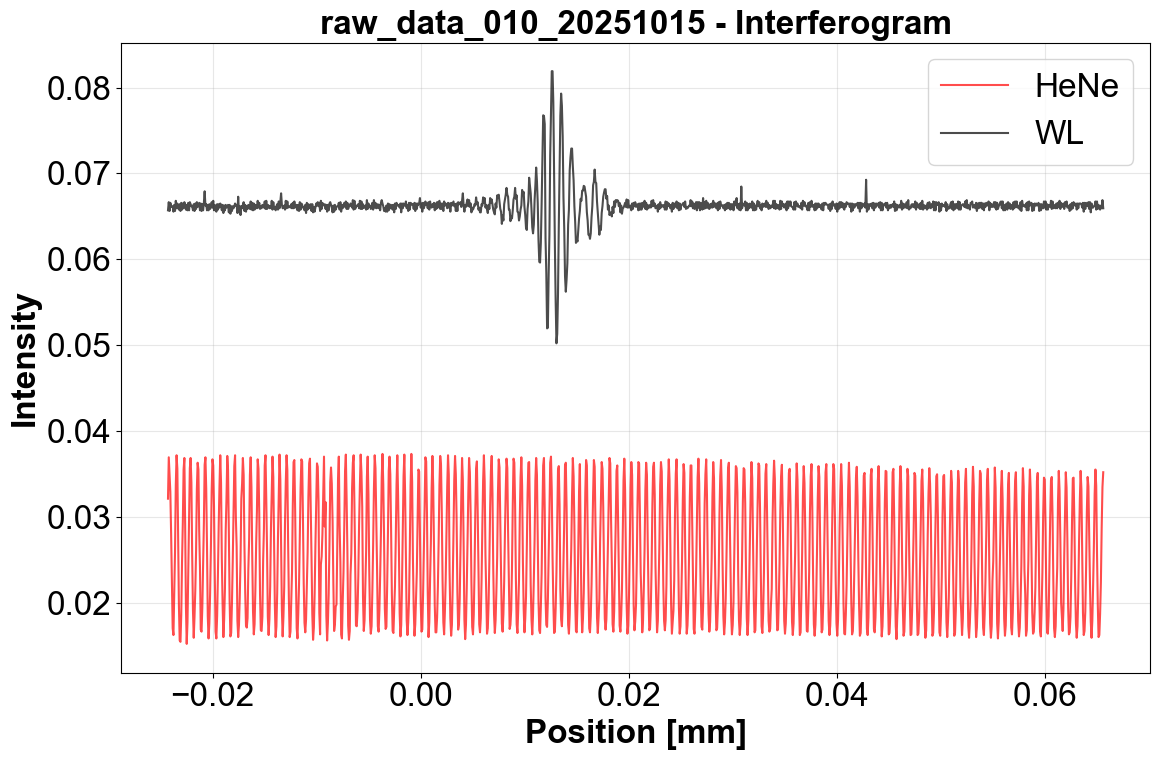

Zero delay correction: 0.031090
Polynomial coefficients: [ 12.6501734  -29.41616812  16.71742202]
Fit domain $\lambda$ = 1.491 to 0.893 $\mu m$
R^2 = 0.8226
GDD at $\lambda$ = 1.166 $\mu m$ (weighted): 13.17 fs^2
  Saved: raw_data_010_20251015_Spectrum_and_Phase.pdf


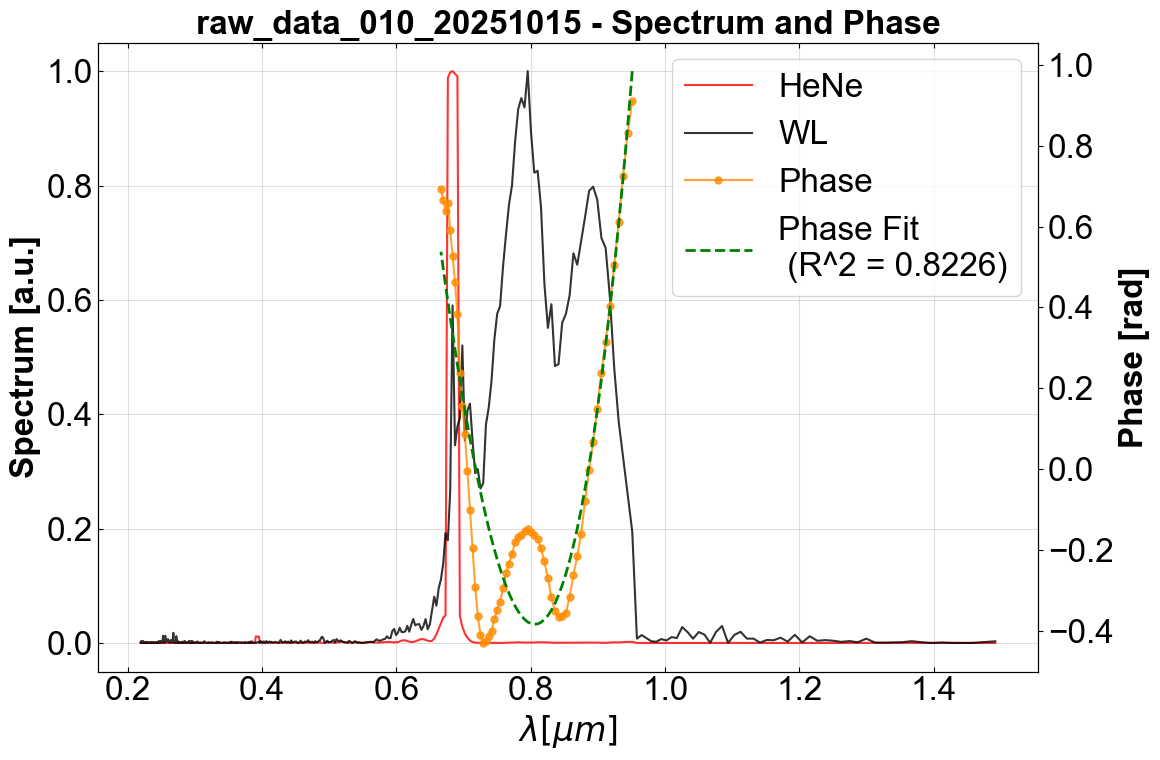


Processing: raw_data_011_20251015
  Saved: raw_data_011_20251015_Interferogram.pdf


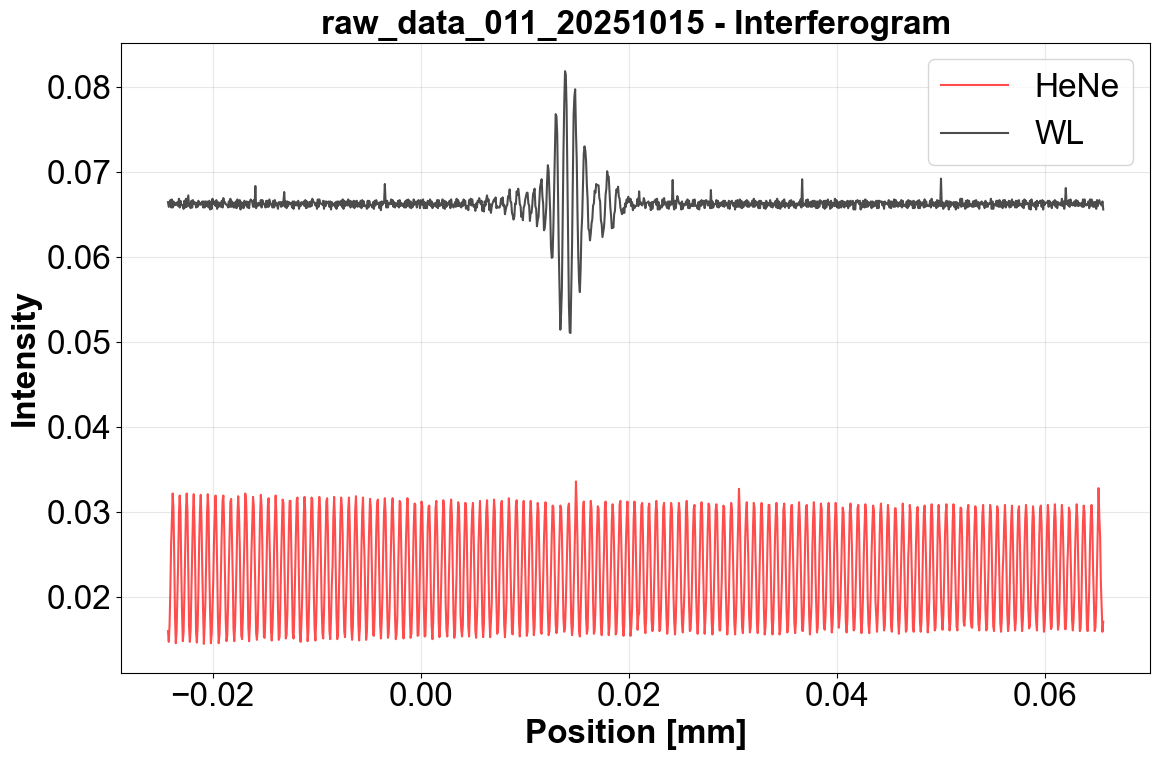

Zero delay correction: 0.030652
Polynomial coefficients: [ 15.18211982 -35.26880898  20.06231102]
Fit domain $\lambda$ = 1.475 to 0.899 $\mu m$
R^2 = 0.8329
GDD at $\lambda$ = 1.162 $\mu m$ (weighted): 15.60 fs^2
  Saved: raw_data_011_20251015_Spectrum_and_Phase.pdf


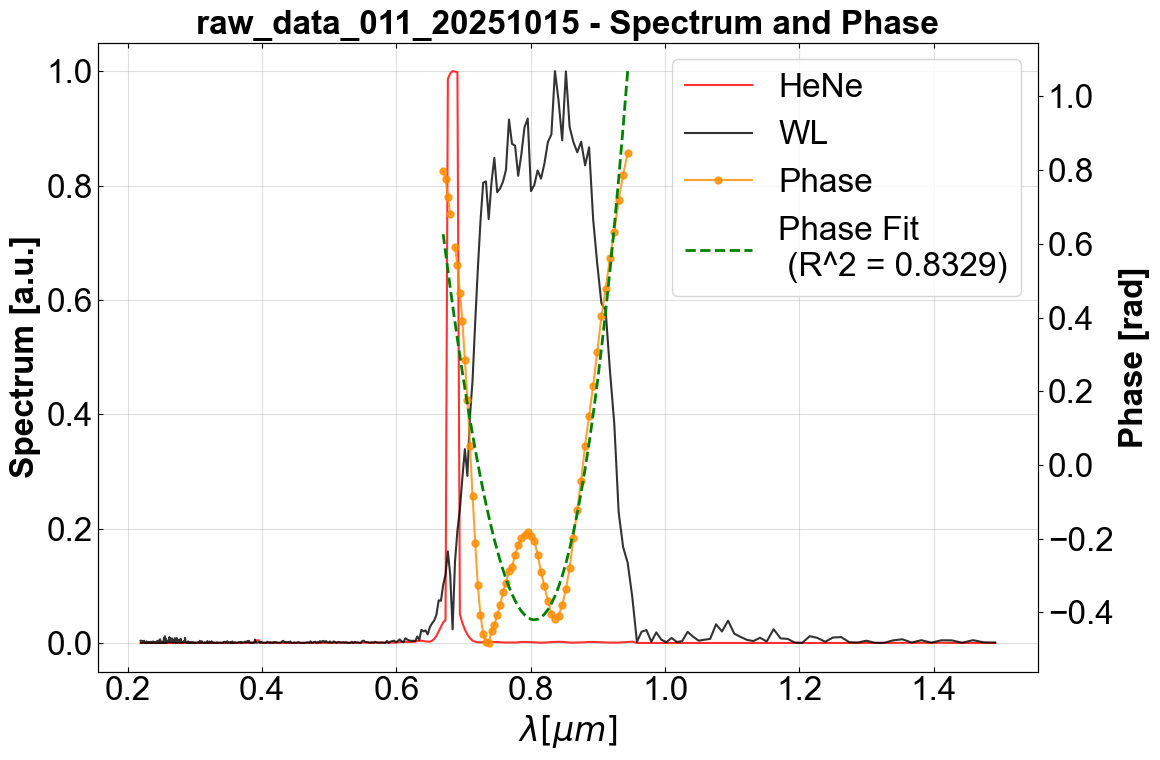


Processing: raw_data_012_20251015
  Saved: raw_data_012_20251015_Interferogram.pdf


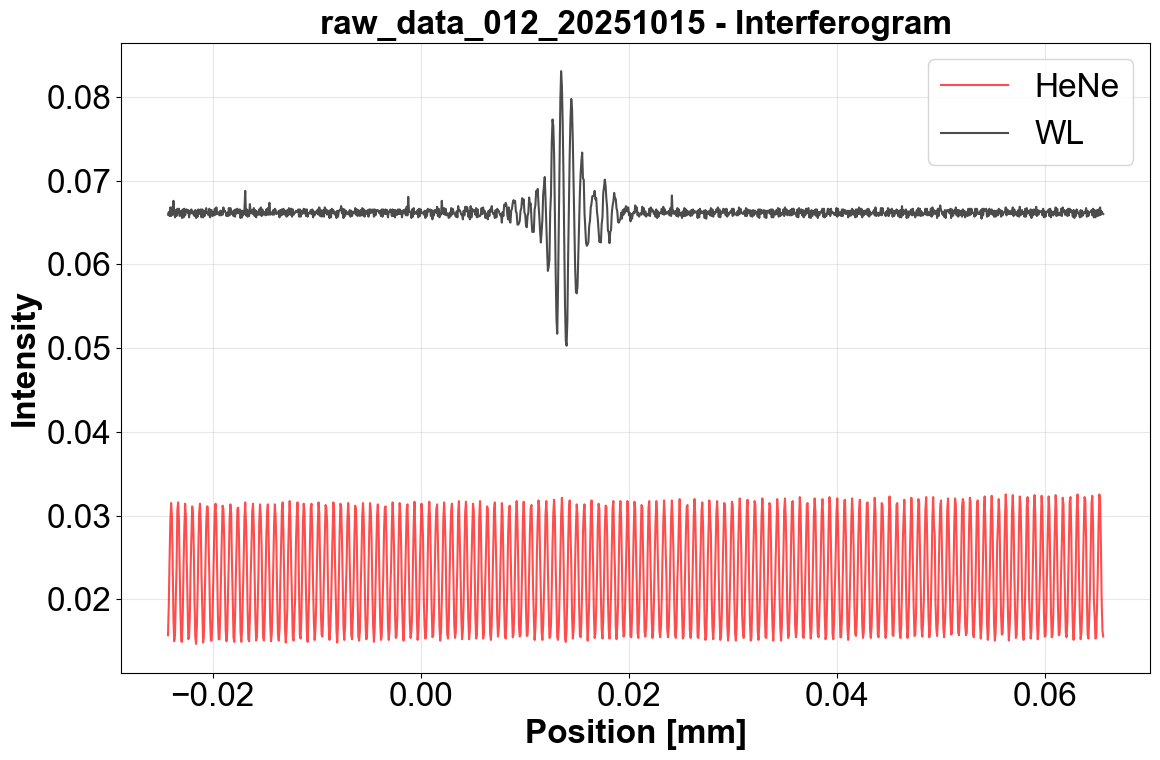

Zero delay correction: 0.030744
Polynomial coefficients: [ 16.19980199 -37.79944229  21.56874095]
Fit domain $\lambda$ = 1.491 to 0.899 $\mu m$
R^2 = 0.8597
GDD at $\lambda$ = 1.185 $\mu m$ (weighted): 17.96 fs^2
  Saved: raw_data_012_20251015_Spectrum_and_Phase.pdf


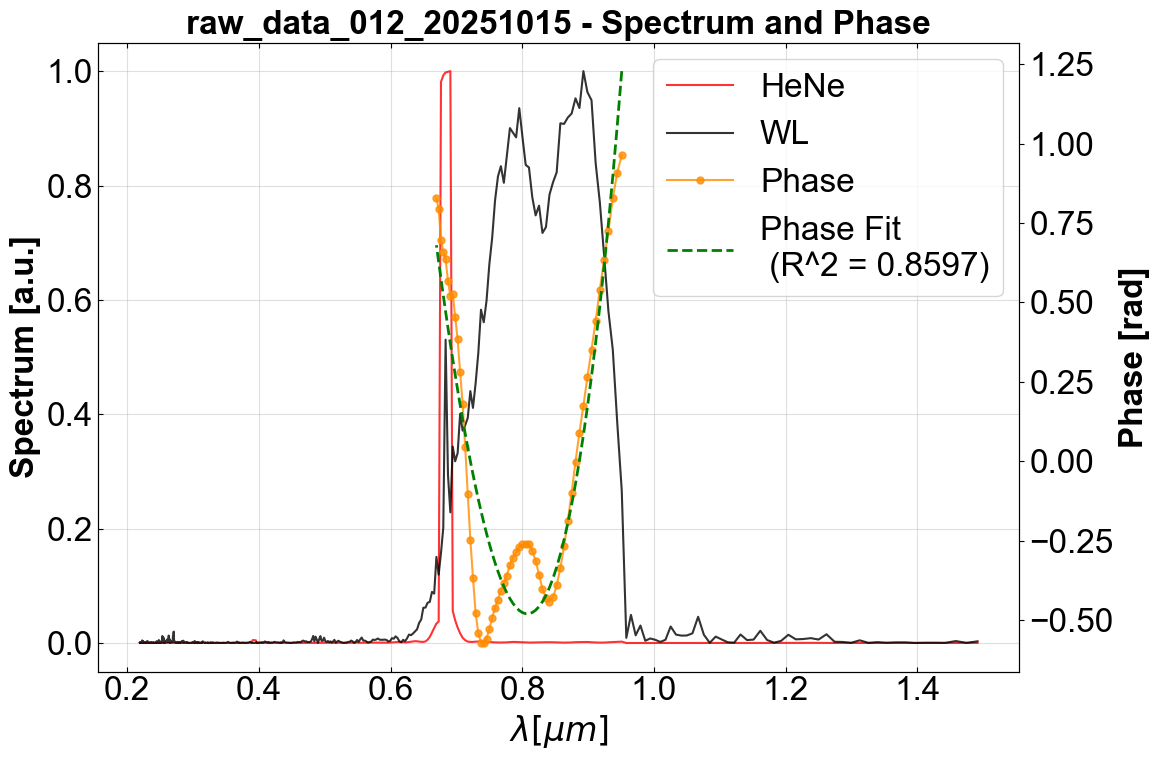


Processing: raw_data_013_20251015
  Saved: raw_data_013_20251015_Interferogram.pdf


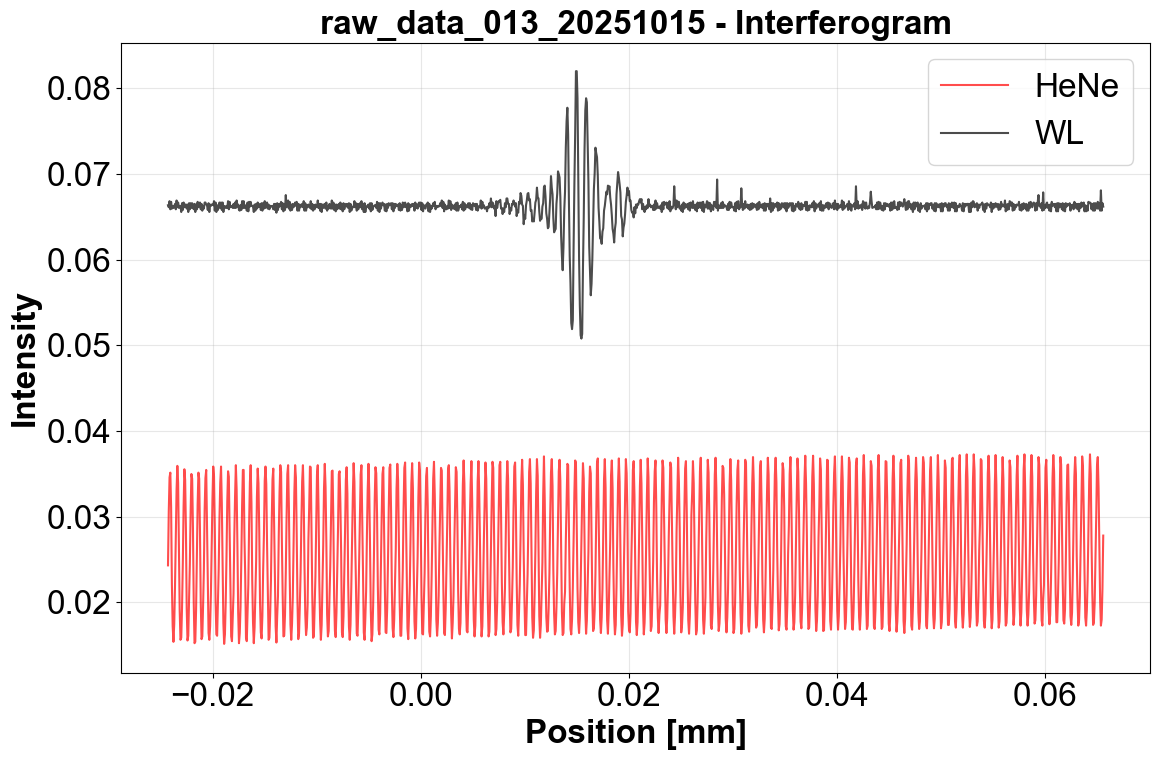

Zero delay correction: 0.030483
Polynomial coefficients: [ 14.78668626 -34.83474226  20.10272428]
Fit domain $\lambda$ = 1.491 to 0.918 $\mu m$
R^2 = 0.7453
GDD at $\lambda$ = 1.187 $\mu m$ (weighted): 16.52 fs^2
  Saved: raw_data_013_20251015_Spectrum_and_Phase.pdf


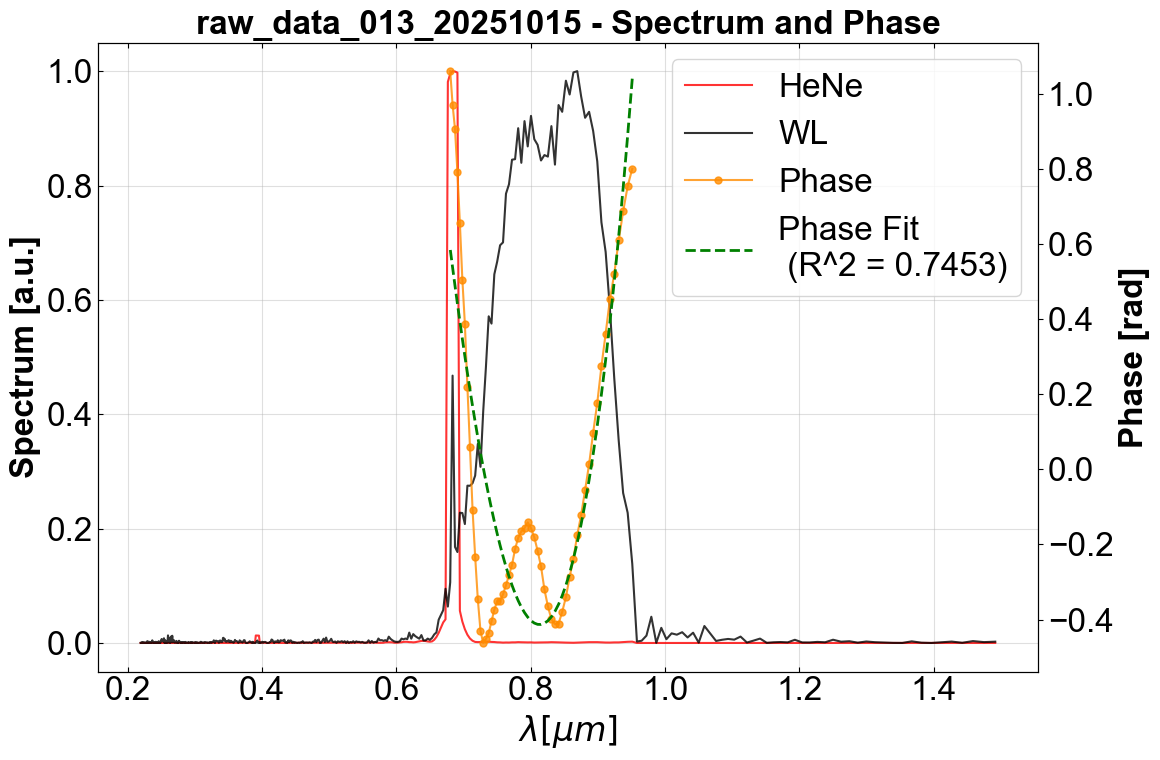


Processing: raw_data_014_20251015
  Saved: raw_data_014_20251015_Interferogram.pdf


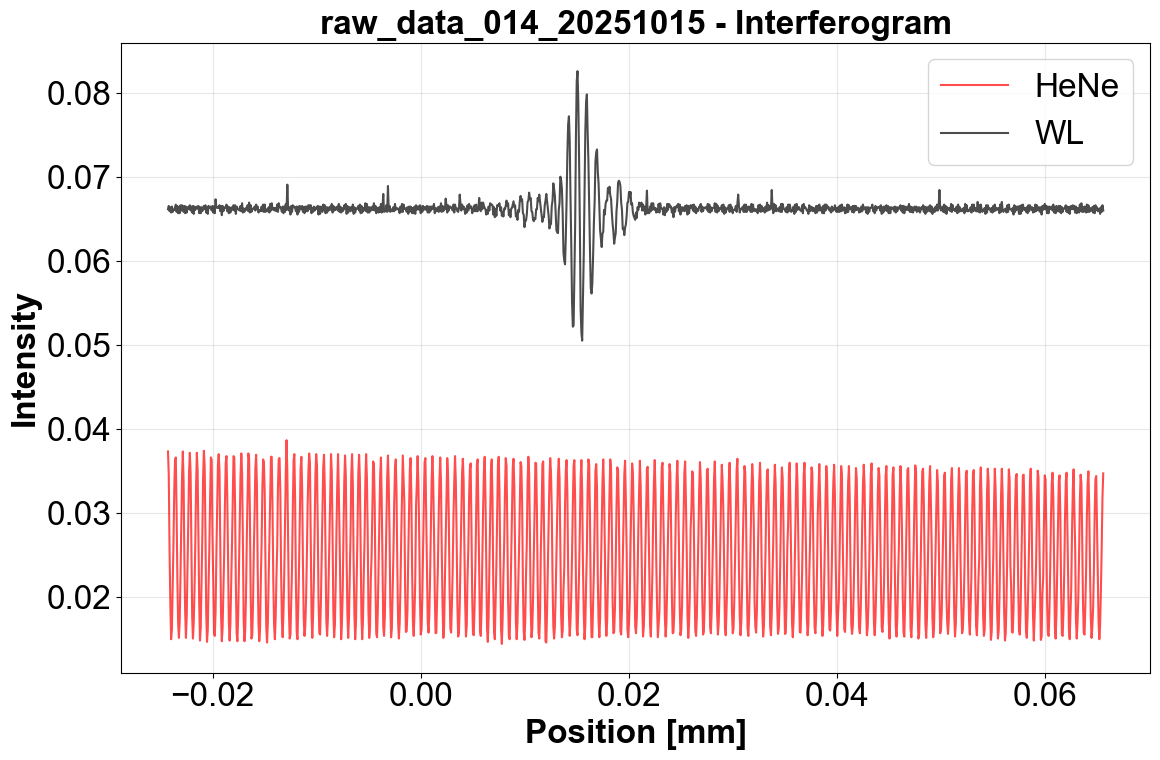

Zero delay correction: 0.028626
Polynomial coefficients: [ 14.72229628 -33.72942708  18.8338799 ]
Fit domain $\lambda$ = 1.491 to 0.863 $\mu m$
R^2 = 0.8730
GDD at $\lambda$ = 1.159 $\mu m$ (weighted): 14.94 fs^2
  Saved: raw_data_014_20251015_Spectrum_and_Phase.pdf


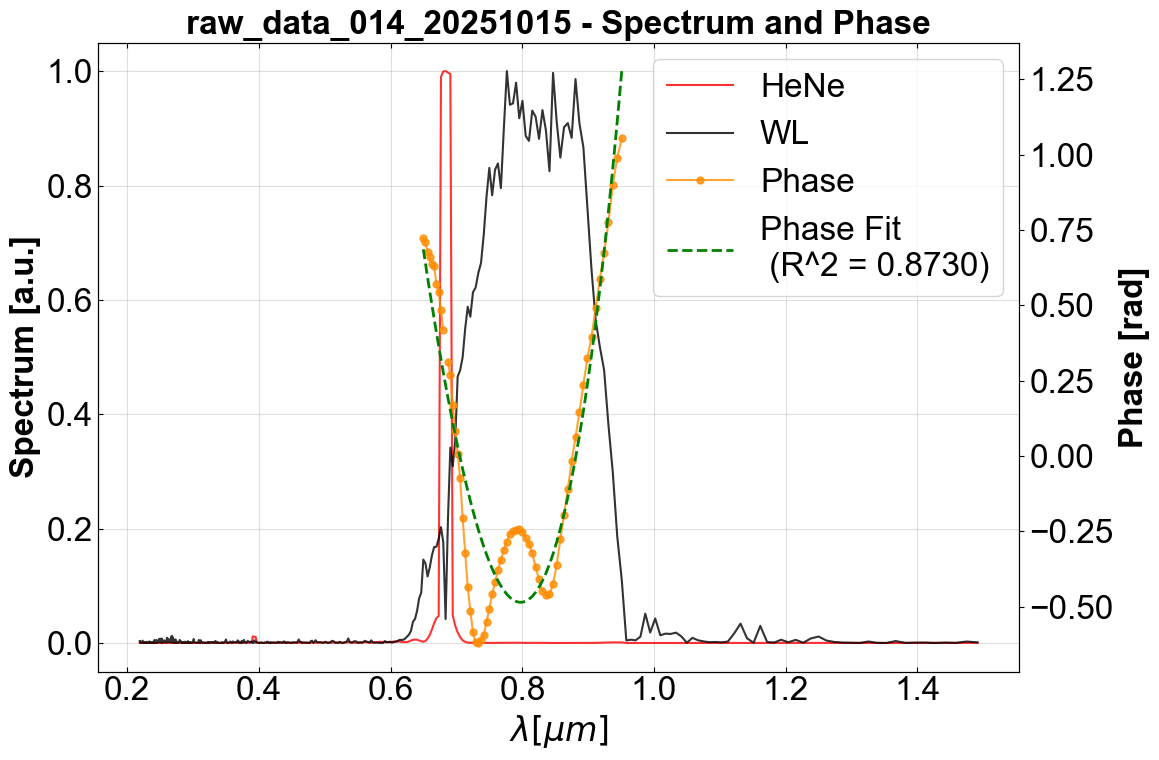


Processing: raw_data_015_20251015
  Skipping raw_data_015_20251015 (in exclusion list)

Processing: raw_data_016_20251015
  Saved: raw_data_016_20251015_Interferogram.pdf


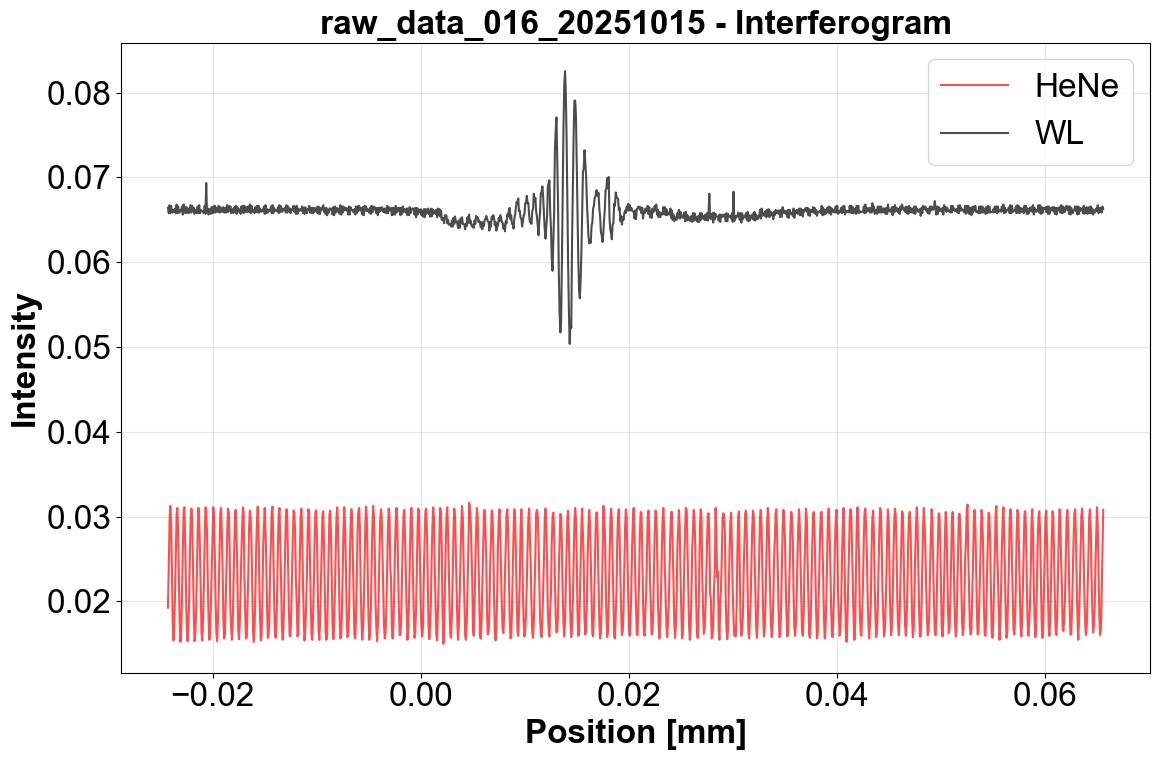

Zero delay correction: 0.030858
Polynomial coefficients: [ 14.56707756 -33.95838038  19.35929508]
Fit domain $\lambda$ = 1.491 to 0.893 $\mu m$
R^2 = 0.7190
GDD at $\lambda$ = 1.224 $\mu m$ (weighted): 18.41 fs^2
  Saved: raw_data_016_20251015_Spectrum_and_Phase.pdf


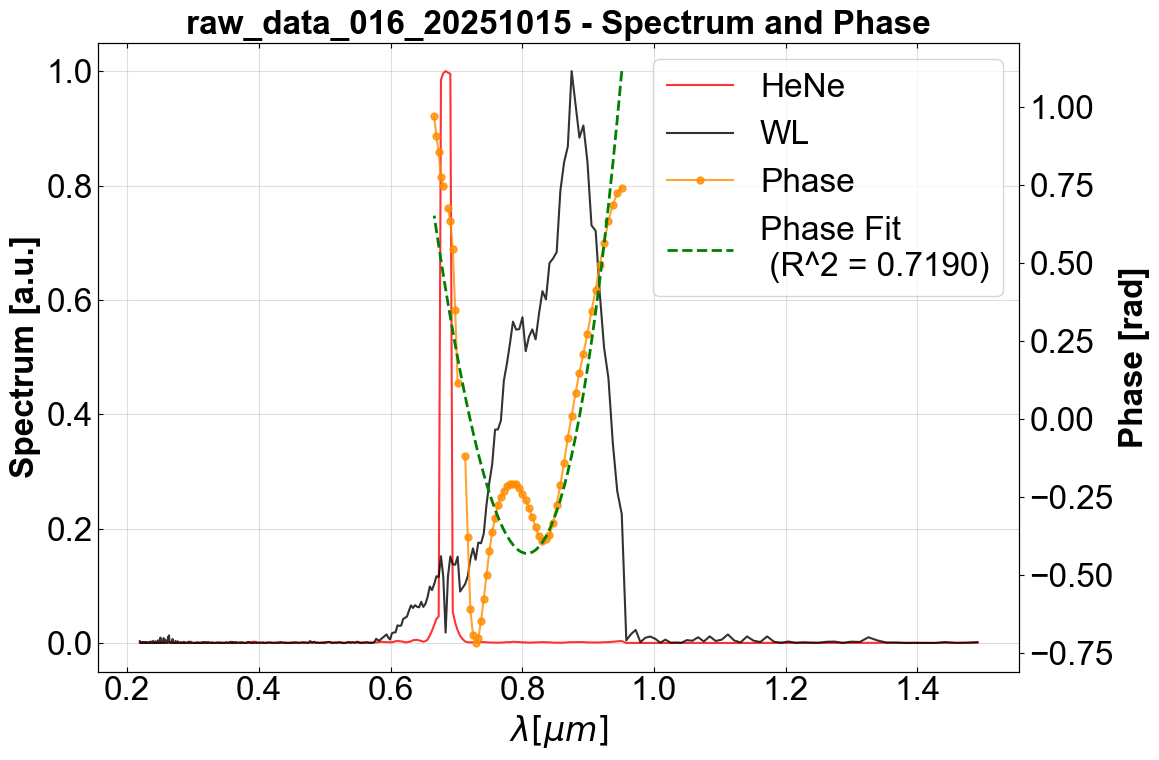


Processing: raw_data_017_20251015
  Saved: raw_data_017_20251015_Interferogram.pdf


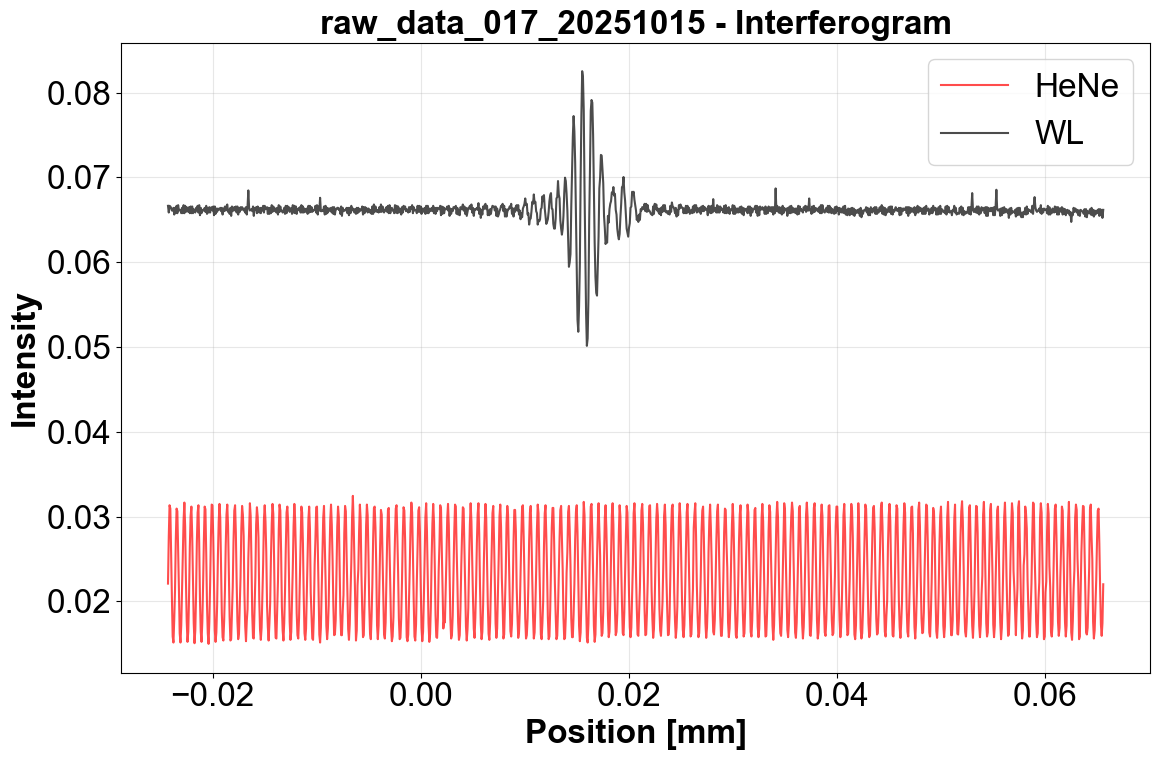

Zero delay correction: 0.030332
Polynomial coefficients: [ 15.11246523 -34.87094887  19.75314176]
Fit domain $\lambda$ = 1.442 to 0.911 $\mu m$
R^2 = 0.8141
GDD at $\lambda$ = 1.154 $\mu m$ (weighted): 15.09 fs^2
  Saved: raw_data_017_20251015_Spectrum_and_Phase.pdf


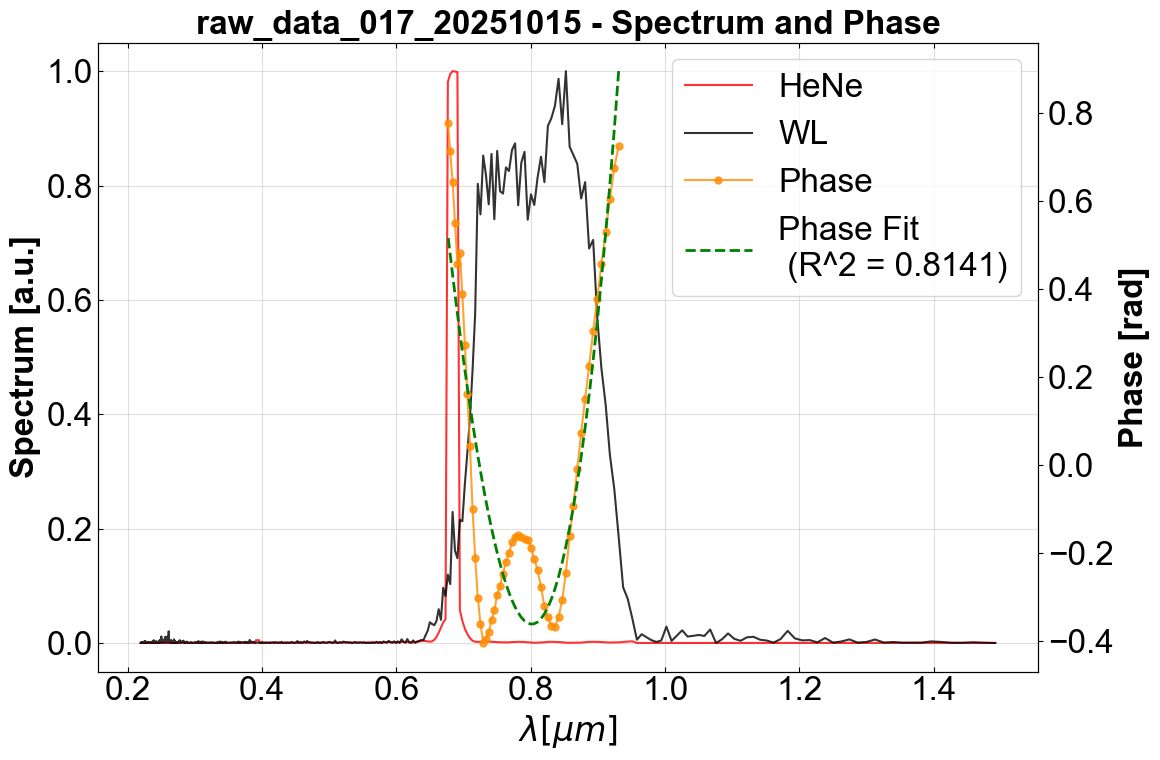


Processing: raw_data_018_20251015
  Saved: raw_data_018_20251015_Interferogram.pdf


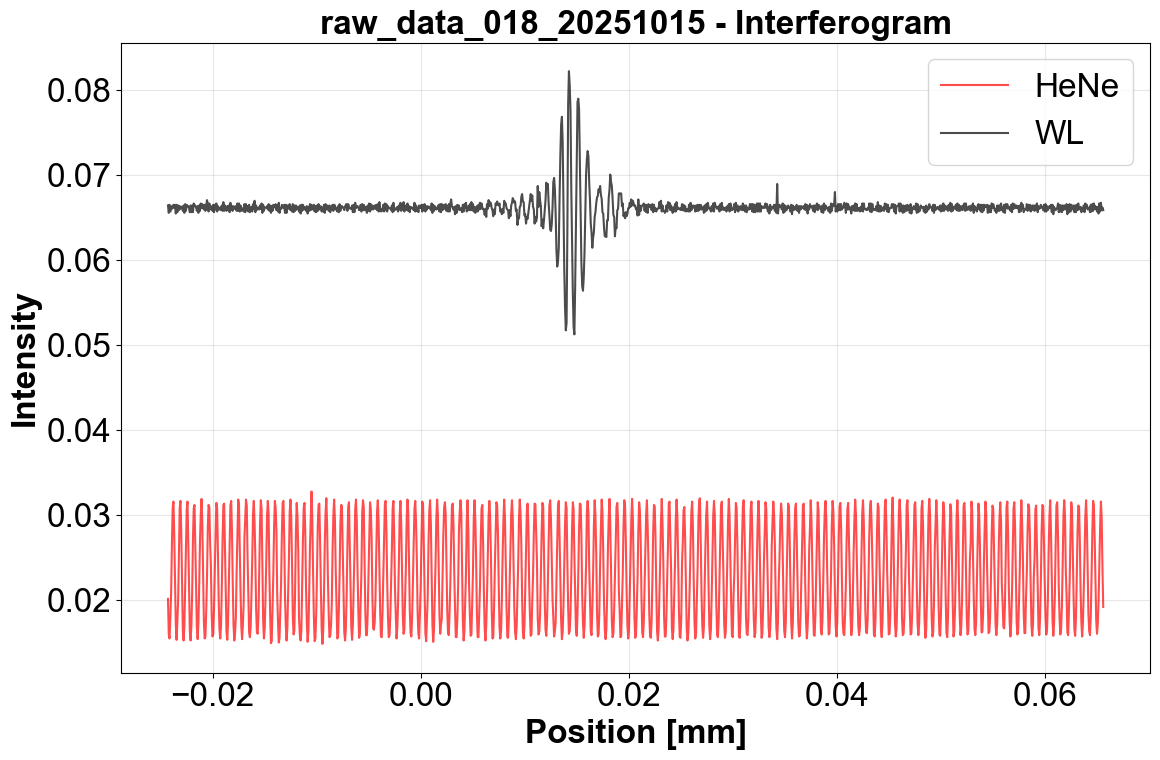

Zero delay correction: 0.026294
Polynomial coefficients: [ 14.55251227 -32.52185521  17.74325692]
Fit domain $\lambda$ = 1.442 to 0.847 $\mu m$
R^2 = 0.8330
GDD at $\lambda$ = 1.110 $\mu m$ (weighted): 12.42 fs^2
  Saved: raw_data_018_20251015_Spectrum_and_Phase.pdf


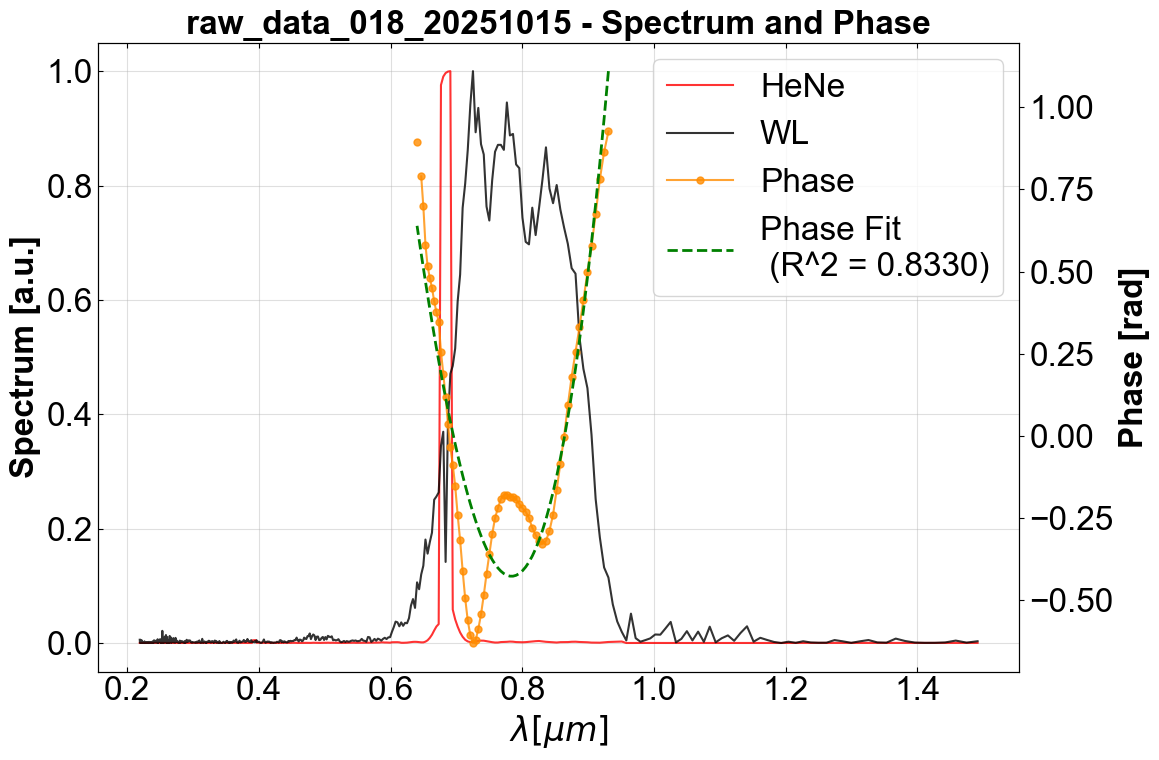


Processing: raw_data_019_20251015
  Saved: raw_data_019_20251015_Interferogram.pdf


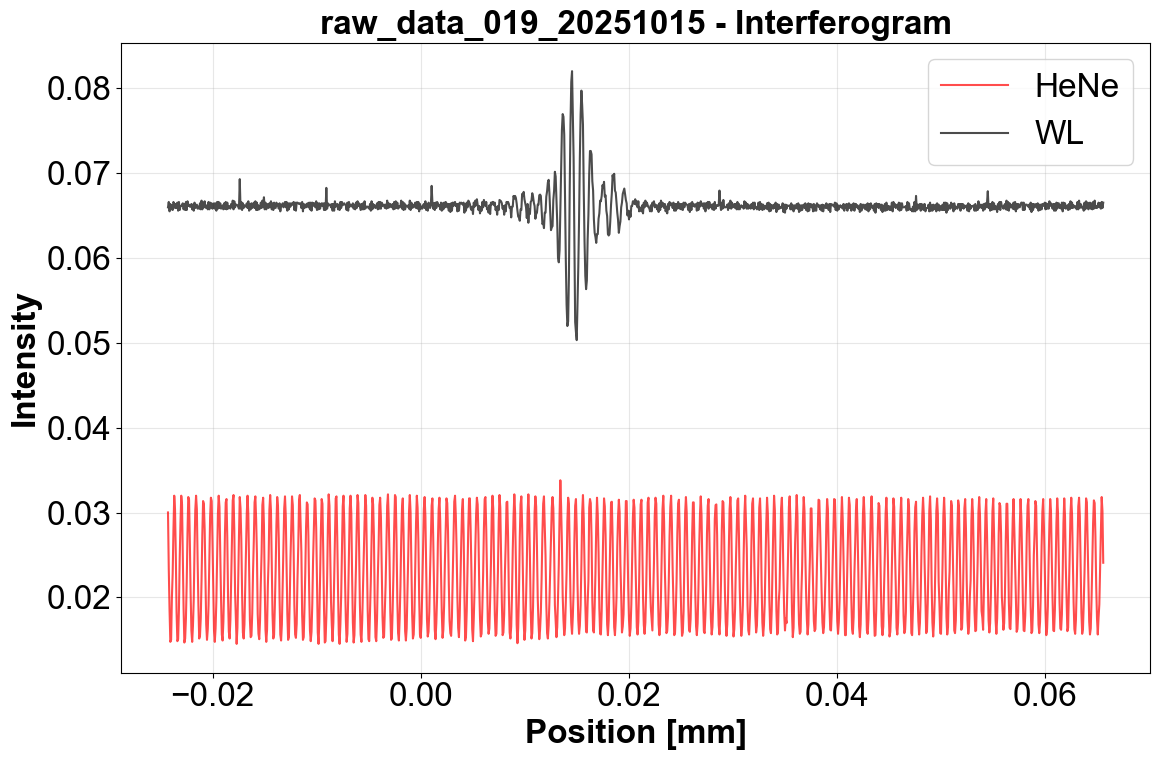

Zero delay correction: 0.027946
Polynomial coefficients: [ 13.99780122 -32.18443313  18.08721165]
Fit domain $\lambda$ = 1.475 to 0.881 $\mu m$
R^2 = 0.7671
GDD at $\lambda$ = 1.172 $\mu m$ (weighted): 14.89 fs^2
  Saved: raw_data_019_20251015_Spectrum_and_Phase.pdf


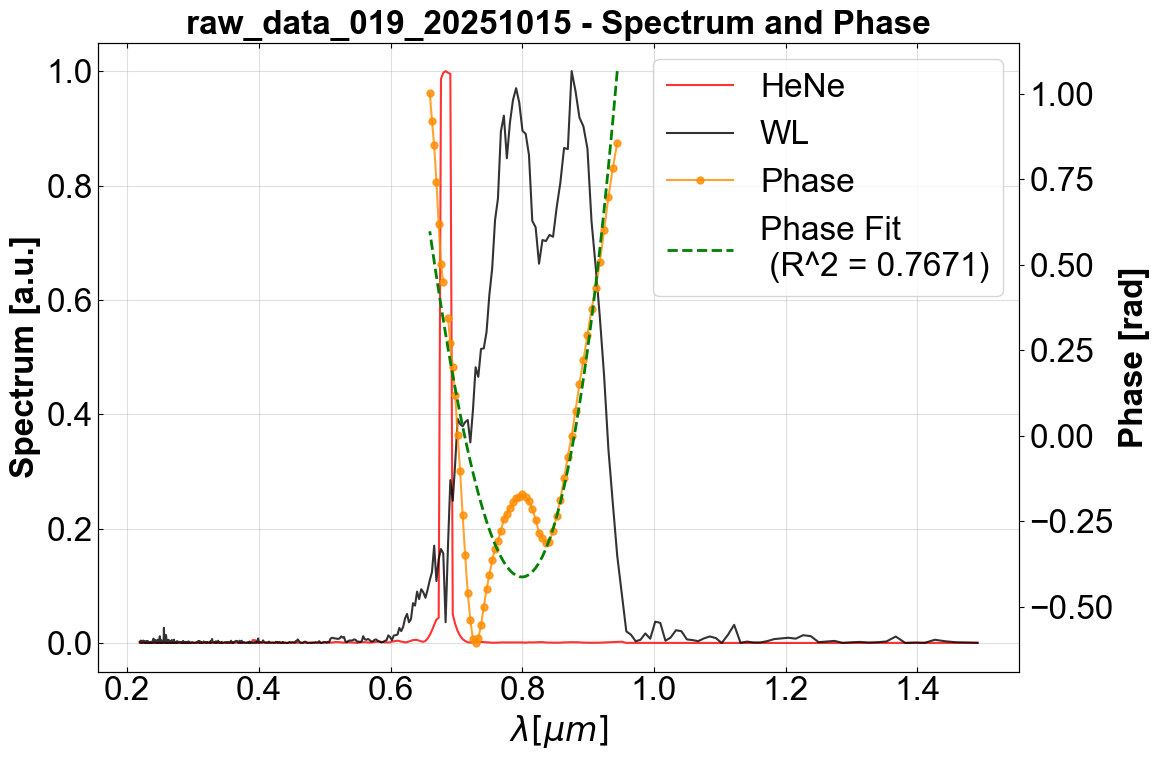


Processing: raw_data_020_20251015
  Saved: raw_data_020_20251015_Interferogram.pdf


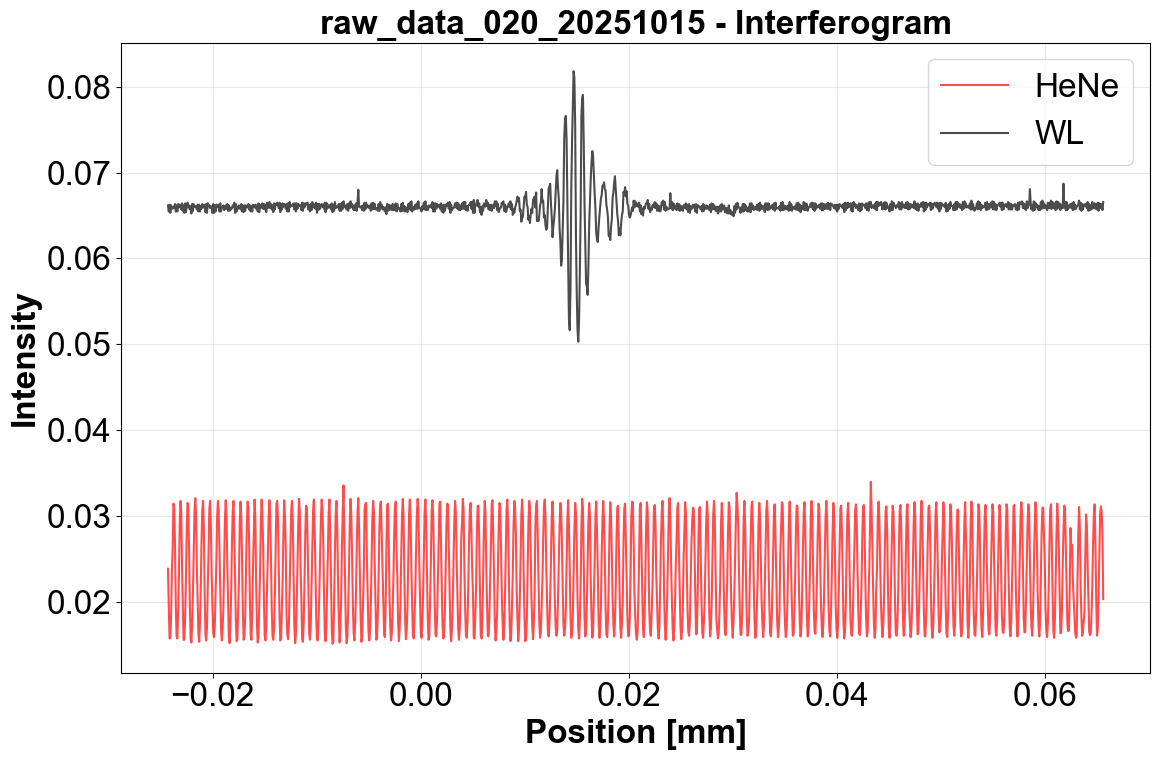

Zero delay correction: 0.026951
Polynomial coefficients: [ 15.39544918 -35.78939923  20.33241105]
Fit domain $\lambda$ = 1.491 to 0.887 $\mu m$
R^2 = 0.9019
GDD at $\lambda$ = 1.165 $\mu m$ (weighted): 15.95 fs^2
  Saved: raw_data_020_20251015_Spectrum_and_Phase.pdf


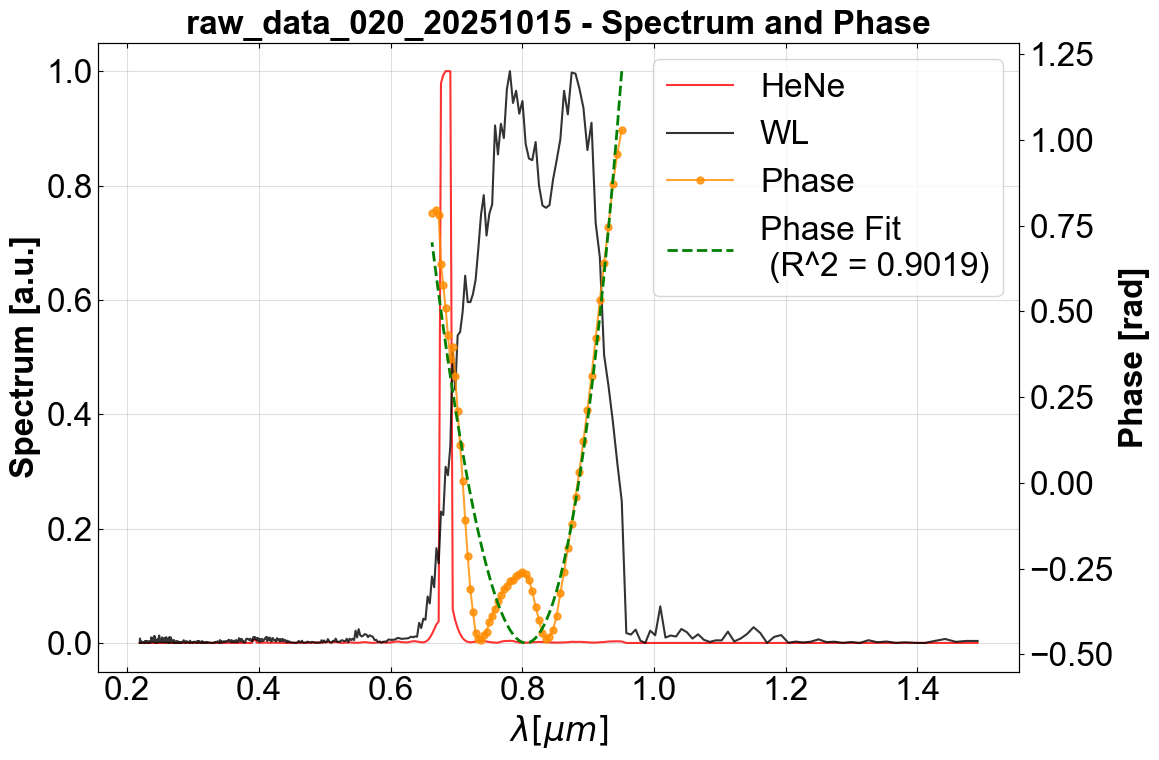


Processing: raw_data_021_20251015
  Skipping raw_data_021_20251015 (in exclusion list)

Processing: raw_data_022_20251015
  Saved: raw_data_022_20251015_Interferogram.pdf


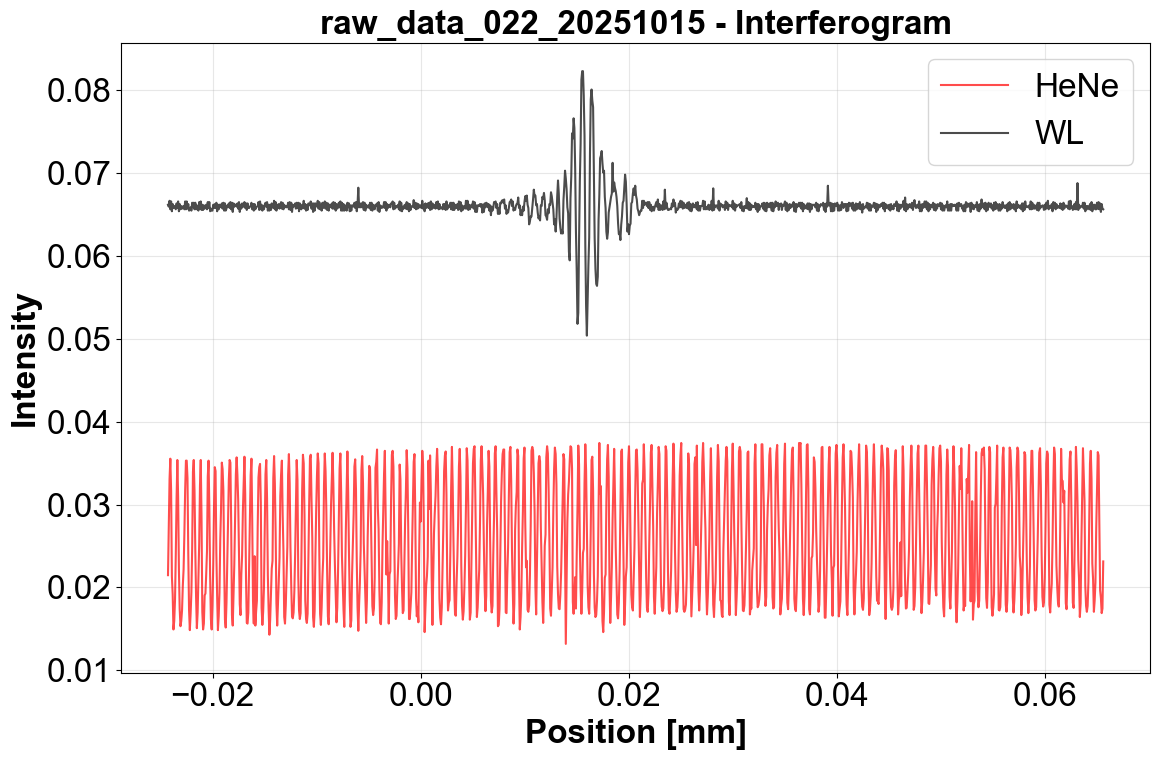

Zero delay correction: 0.030107
Polynomial coefficients: [ 13.9119063  -32.9862328   19.18084908]
Fit domain $\lambda$ = 1.491 to 0.931 $\mu m$
R^2 = 0.6614
GDD at $\lambda$ = 1.217 $\mu m$ (weighted): 17.17 fs^2
  Saved: raw_data_022_20251015_Spectrum_and_Phase.pdf


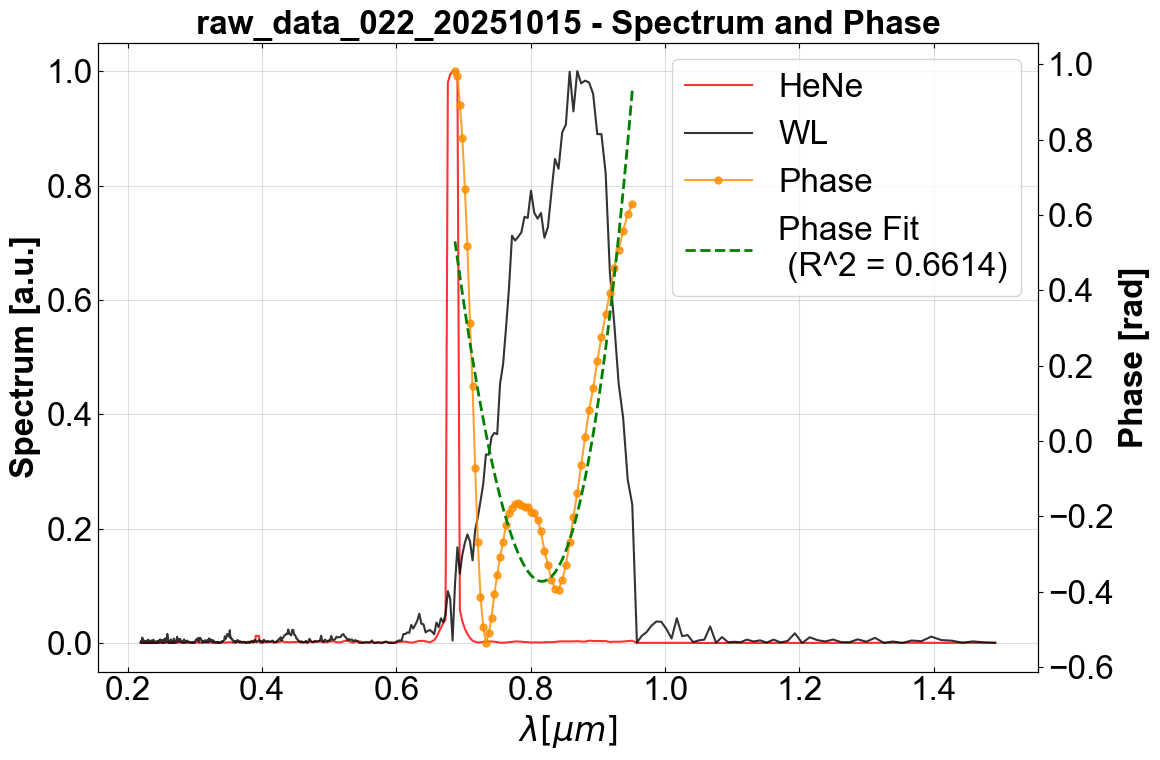


Processing: raw_data_023_20251015
  Saved: raw_data_023_20251015_Interferogram.pdf


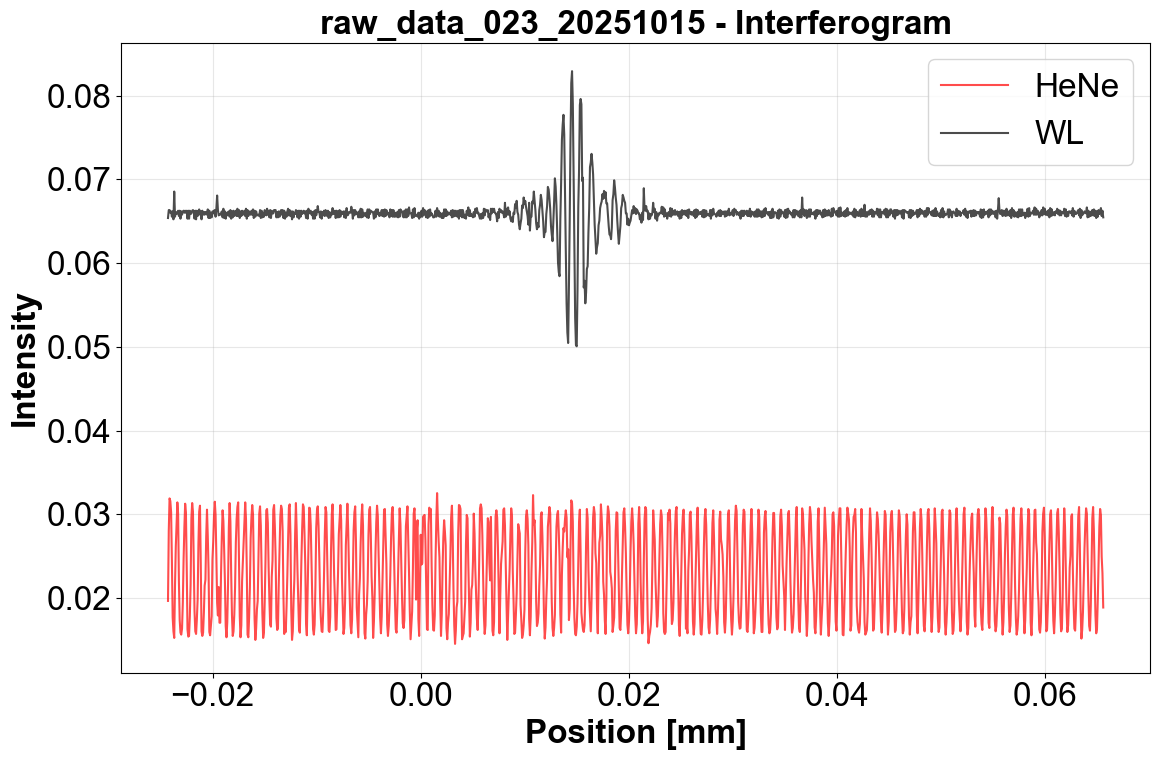

Zero delay correction: 0.030499
Polynomial coefficients: [ 11.5746094  -26.66753793  14.98960238]
Fit domain $\lambda$ = 1.491 to 0.875 $\mu m$
R^2 = 0.8172
GDD at $\lambda$ = 1.157 $\mu m$ (weighted): 11.68 fs^2
  Saved: raw_data_023_20251015_Spectrum_and_Phase.pdf


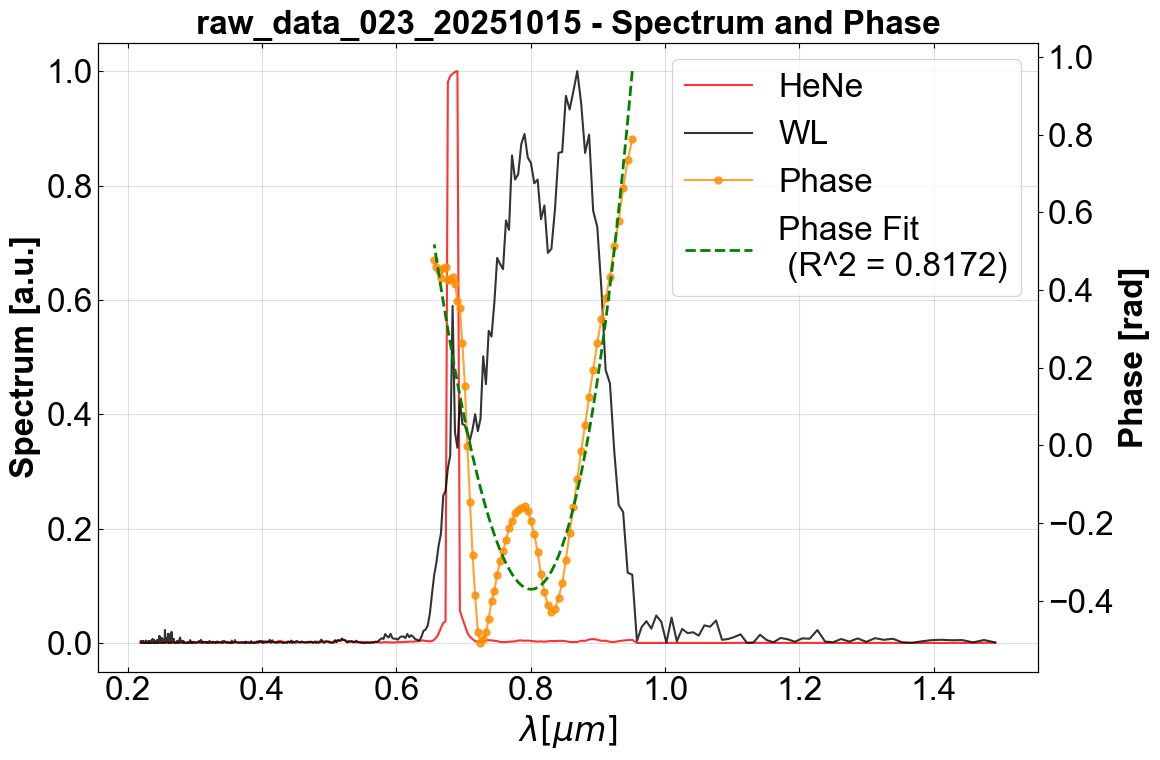


Processing: raw_data_024_20251015
  Saved: raw_data_024_20251015_Interferogram.pdf


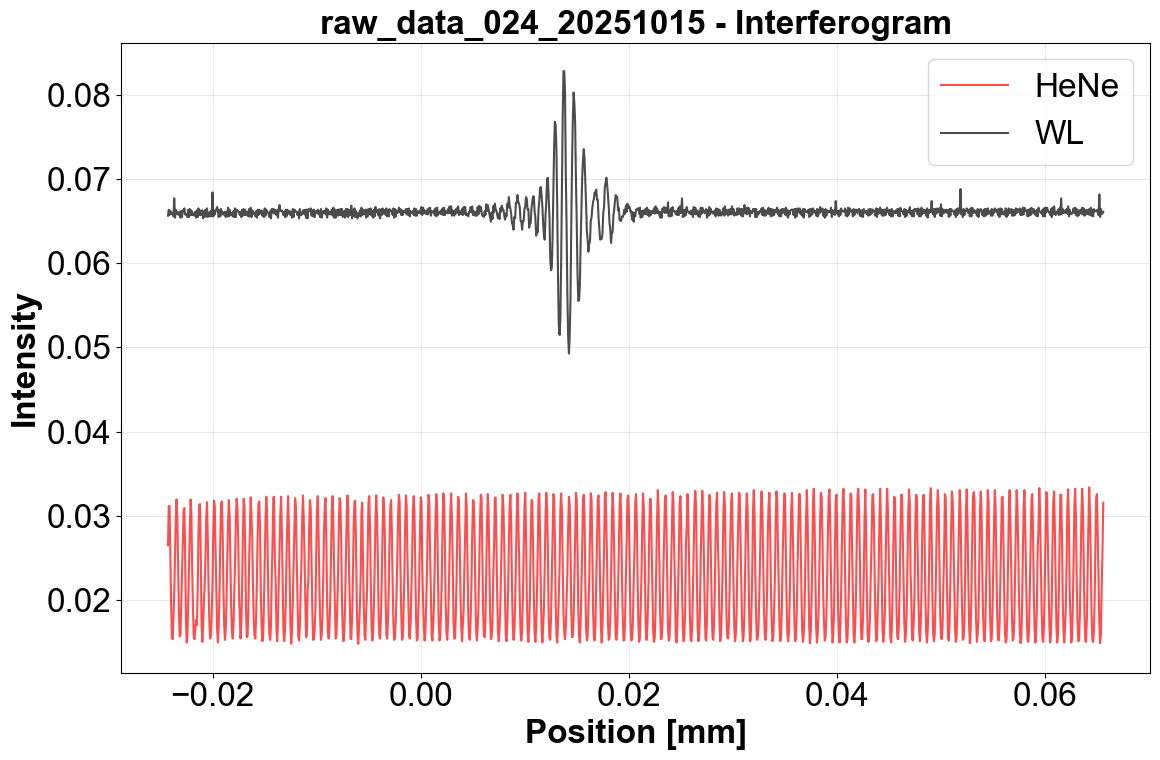

Zero delay correction: 0.030728
Polynomial coefficients: [ 16.97955115 -39.61619419  22.64932067]
Fit domain $\lambda$ = 1.475 to 0.905 $\mu m$
R^2 = 0.7754
GDD at $\lambda$ = 1.181 $\mu m$ (weighted): 18.61 fs^2
  Saved: raw_data_024_20251015_Spectrum_and_Phase.pdf


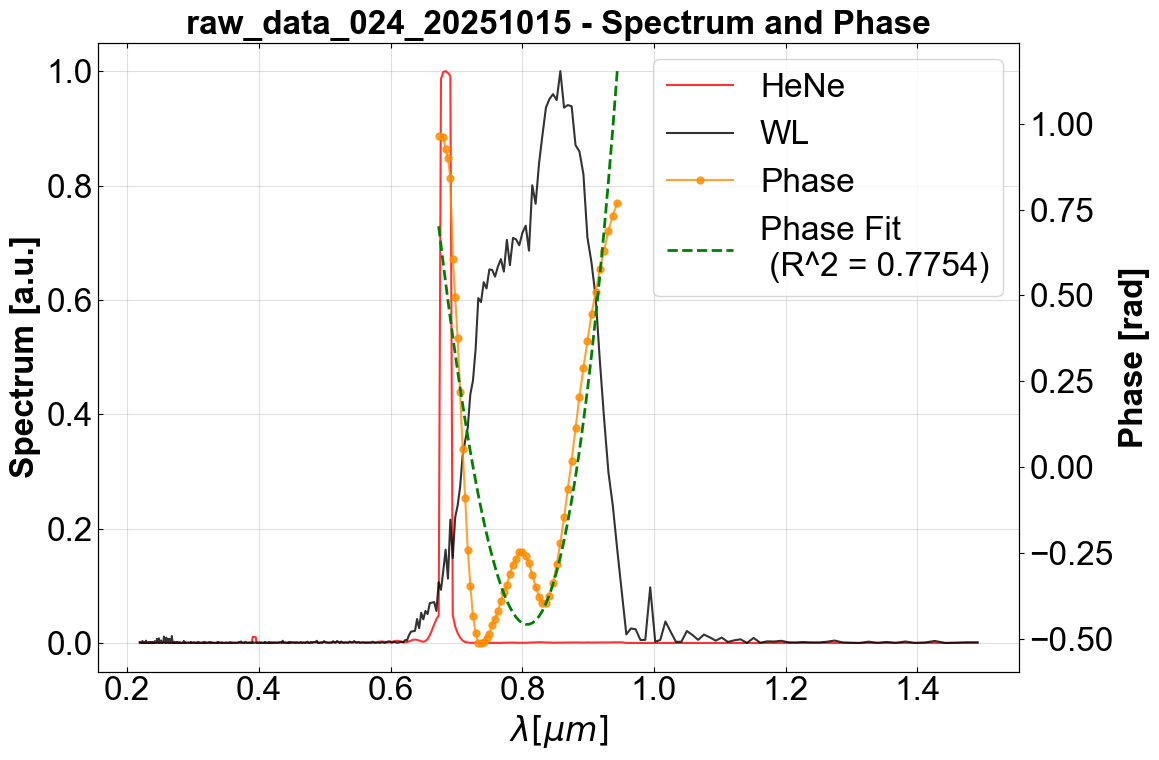


Processing: raw_data_025_20251015
  Saved: raw_data_025_20251015_Interferogram.pdf


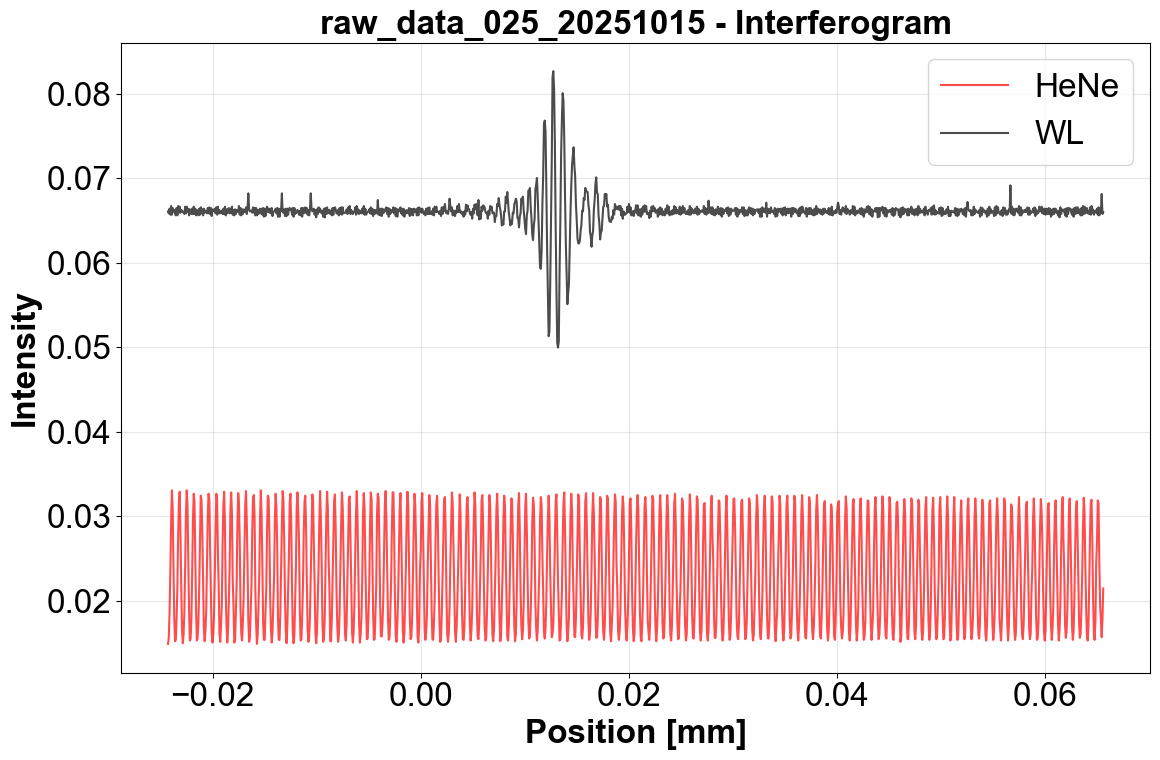

Error processing raw_data_025_20251015: `x` must be strictly increasing sequence.


Calculating averaged spectrum and phase...
Averaged 22 datasets
Average phase polynomial coefficients: [ 13.19538509 -30.67485144  17.44437807]
Average fit domain $\lambda$ = 1.491 to 0.847 $\mu m$
R^2 = 0.8622
Average GDD at $\lambda$ = 1.171 $\mu m$: 13.98 fs^2


/tmp/ipykernel_20029/3516976229.py:153: RuntimeWarning: Mean of empty slice
  phase_avg = np.nanmean(phases_interp, axis=0)


  Saved: Averaged_Spectrum_and_Phase_NoGlass.pdf


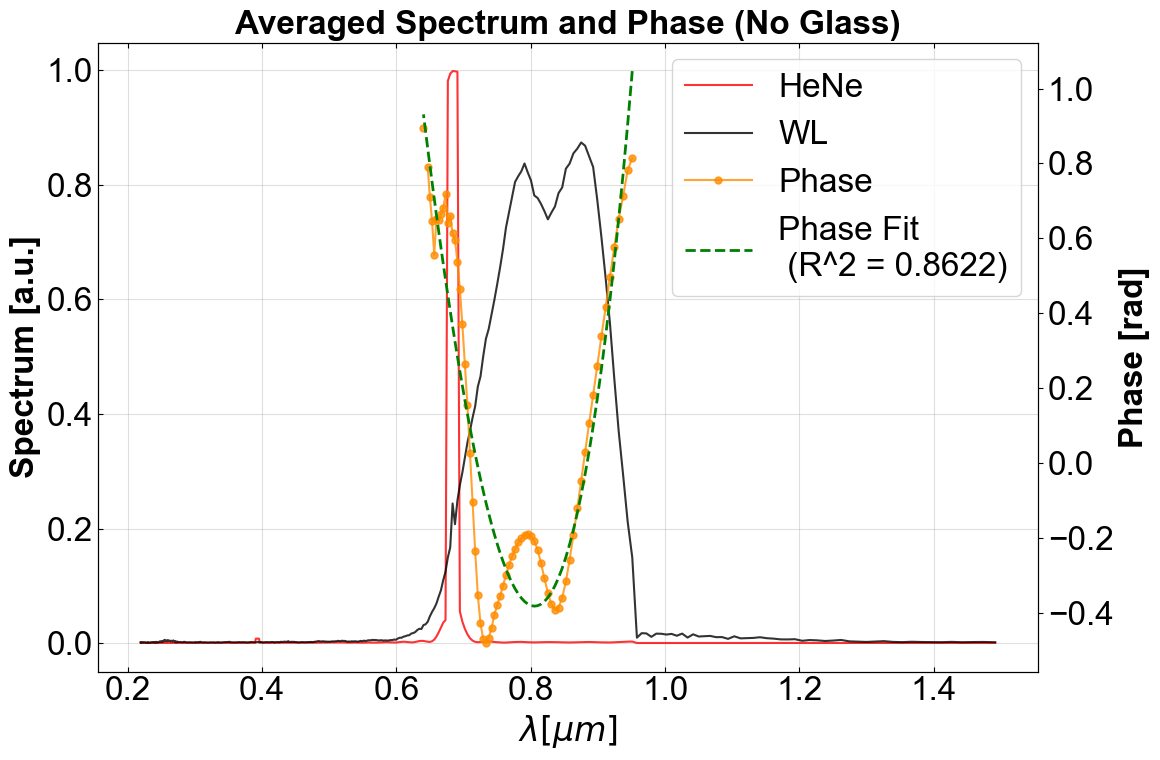

In [24]:
# Main processing script
if __name__ == '__main__':
    # Path to data
    path = '../Team32025/WLI_establish_20251015/'
    data = extract_data(path)
    
    start_idx = 700
    end_idx = 1900
    
    # Set to True to show diagnostic plots
    show_diagnostics = True
    
    save_figures = True
    output_dir = 'Plots/NoGlass'  # Directory to save figures
    
    # NEW: Set the x-axis shift amount (in indices)
    # Positive values shift right, negative shift left
    X_SHIFT_AMOUNT = 50  # Example: shift by 50 indices to the right
    # X_SHIFT_AMOUNT = -30  # Example: shift by 30 indices to the left
    # X_SHIFT_AMOUNT = 0  # No shift

    exclude = ['raw_data_015_20251015',
               'raw_data_021_20251015']
    
    # Create output directory if it doesn't exist
    if save_figures:
        os.makedirs(output_dir, exist_ok=True)
    
    # Store for averaged results
    all_spectrums = []
    all_phases = []
    all_lambdas = []
    
    print(f'Processing data from index {start_idx} to {end_idx}')
    print(f'Found {len([k for k in data.keys() if k.endswith("_HN_data")])} datasets')
    print(f'X-axis shift amount: {X_SHIFT_AMOUNT} indices\n')
    
    # Process each dataset
    for key in sorted(data.keys()):
        if key.endswith('_HN_data'):
            base_key = key[:-8]
            wl_key = f'{base_key}_WL_data'
            meta_key = f'{base_key}_meta'
            
            if wl_key in data:
                print(f'Processing: {base_key}')
                
                if base_key in exclude:
                    print(f'  Skipping {base_key} (in exclusion list)')
                    print()
                    continue
                
                # Get xLinear from metadata or create default
                if meta_key in data and 'xLinear' in data[meta_key]:
                    xL = data[meta_key]['xLinear'].flatten()
                else:
                    # Create default linear axis
                    N = len(data[key])
                    xL = np.linspace(0, 1, N)
                
                # Create data array
                dataArray = np.column_stack([data[key], data[wl_key]])

                if show_diagnostics:
                    if start_idx is not None and end_idx is not None:
                        dataArray_slice = dataArray[start_idx:end_idx, :]
                        xL_slice = xL[start_idx:end_idx]
                    else:
                        dataArray_slice = dataArray
                        xL_slice = xL
    
                    fig = plot_diagnostic(dataArray_slice, xL_slice, 
                                         title=f'{base_key} - Interferogram',
                                         save_fig=save_figures,
                                         output_dir=output_dir,
                                         filename=f'{base_key}_Interferogram')
                    plt.show()
                    plt.close(fig)
                        
                # Process the data
                try:
                    xCen, spectrum, wLPhase, lambda_vals, w_vals = WLI_processData(
                        dataArray, xL, start_idx, end_idx
                    ) 
                
                    
                    # Fit phase with 2nd degree polynomial
                    coeffs, phase_fit, lambda_trim, phase_trim, spectrum_trim, r_squared = fit_phase_polynomial(lambda_vals, wLPhase, spectrum, degree=2)
                    
                    if coeffs is not None:
                        print(f'Zero delay correction: {xCen:.6f}')
                        print(f'Polynomial coefficients: {coeffs}')
                        print(rf'Fit domain $\lambda$ = {lambda_trim[0]:.3f} to {lambda_trim[-1]:.3f} $\mu m$')
                        print(rf'R^2 = {r_squared:.4f}')
                        
                        # GDD calculation
                        GDD, lambda_center = calculate_GDD(coeffs, lambda_trim, spectrum_trim)
                        print(rf'GDD at $\lambda$ = {lambda_center:.3f} $\mu m$ (weighted): {GDD:.2f} fs^2')

                        
                        # Store for averaging
                        all_spectrums.append(spectrum)
                        all_phases.append(wLPhase)
                        all_lambdas.append(lambda_vals)
                        
                        # Plot with x_shift parameter
                        fig, axes = plot_spectrum_and_phase(
                            lambda_vals, spectrum, wLPhase, phase_fit, 
                            lambda_trim, phase_trim, r_squared=r_squared,
                            title=f"{base_key} - Spectrum and Phase",
                            save_fig=save_figures,
                            output_dir=output_dir,
                            filename=f'{base_key}_Spectrum_and_Phase',
                            x_shift=X_SHIFT_AMOUNT)  # Apply the shift here
                        plt.show()
                        plt.close(fig)
                    else:
                        print(f'Warning: Could not fit polynomial (not enough valid phase points)')
                    
                except Exception as e:
                    print(f'Error processing {base_key}: {str(e)}')
                
                print()
    
    # Calculate and plot averaged results
    if len(all_spectrums) > 0:
        print('\nCalculating averaged spectrum and phase...')
        
        # Make sure all have same wavelength axis (interpolate if needed)
        lambda_common = all_lambdas[0]
        
        spectrums_interp = []
        phases_interp = []
        
        for spec, phase, lam in zip(all_spectrums, all_phases, all_lambdas):
            if not np.array_equal(lam, lambda_common):
                # Interpolate to common wavelength axis
                f_spec_hene = interp1d(lam, spec[:, 0], bounds_error=False, fill_value=np.nan)
                f_spec_wl = interp1d(lam, spec[:, 1], bounds_error=False, fill_value=np.nan)
                f_phase = interp1d(lam, phase, bounds_error=False, fill_value=np.nan)
                
                spec_interp = np.column_stack([f_spec_hene(lambda_common), f_spec_wl(lambda_common)])
                phase_interp = f_phase(lambda_common)
            else:
                spec_interp = spec
                phase_interp = phase
            
            spectrums_interp.append(spec_interp)
            phases_interp.append(phase_interp)
        
        # Calculate average (ignoring NaNs)
        spectrum_avg = np.nanmean(spectrums_interp, axis=0)
        phase_avg = np.nanmean(phases_interp, axis=0)
        
        # Fit averaged phase
        coeffs_avg, phase_fit_avg, lambda_trim_avg, phase_trim_avg, spectrum_trim_avg, r_squared_avg = fit_phase_polynomial(lambda_common, phase_avg, spectrum_avg, degree=2)
        
        print(f'Averaged {len(all_spectrums)} datasets')
        print(f'Average phase polynomial coefficients: {coeffs_avg}')
        if lambda_trim_avg is not None:
            print(rf'Average fit domain $\lambda$ = {lambda_trim_avg[0]:.3f} to {lambda_trim_avg[-1]:.3f} $\mu m$')
            print(f'R^2 = {r_squared_avg:.4f}')    
            
            # Average GDD calculation
            GDD_avg, lambda_center_avg = calculate_GDD(coeffs_avg, lambda_trim_avg, spectrum_trim_avg)
            print(rf'Average GDD at $\lambda$ = {lambda_center_avg:.3f} $\mu m$: {GDD_avg:.2f} fs^2')
        
        # Plot averaged spectra and phase with x_shift
        fig, axes = plot_spectrum_and_phase(
            lambda_common, spectrum_avg, phase_avg, phase_fit_avg, 
            lambda_trim_avg, phase_trim_avg, r_squared=r_squared_avg,
            title='Averaged Spectrum and Phase (No Glass)',
            save_fig=save_figures,
            output_dir=output_dir,
            filename='Averaged_Spectrum_and_Phase_NoGlass',
            x_shift=X_SHIFT_AMOUNT)  # Apply shift to averaged plot too
        plt.show()
        plt.close(fig)